In [ ]:
!pip install qiskit[visualization] qiskit-aer rustworkx scipy matplotlib qiskit_algorithms --quiet

# Node = 5

## depth = 1

In [ ]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from typing import Sequence

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler

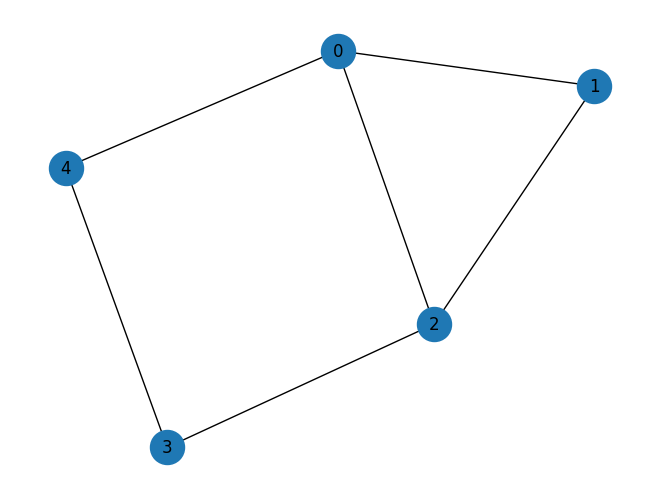

In [ ]:
n = 5
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(n))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [ ]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, list[int], float]]:
    pauli_list = []
    for u, v in graph.edge_list():
        weight = graph.get_edge_data(u, v)
        pauli_list.append(("ZZ", [u, v], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, num_qubits=n)
print("Cost Function Hamiltonian:\n", cost_hamiltonian)

Cost Function Hamiltonian:
 SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


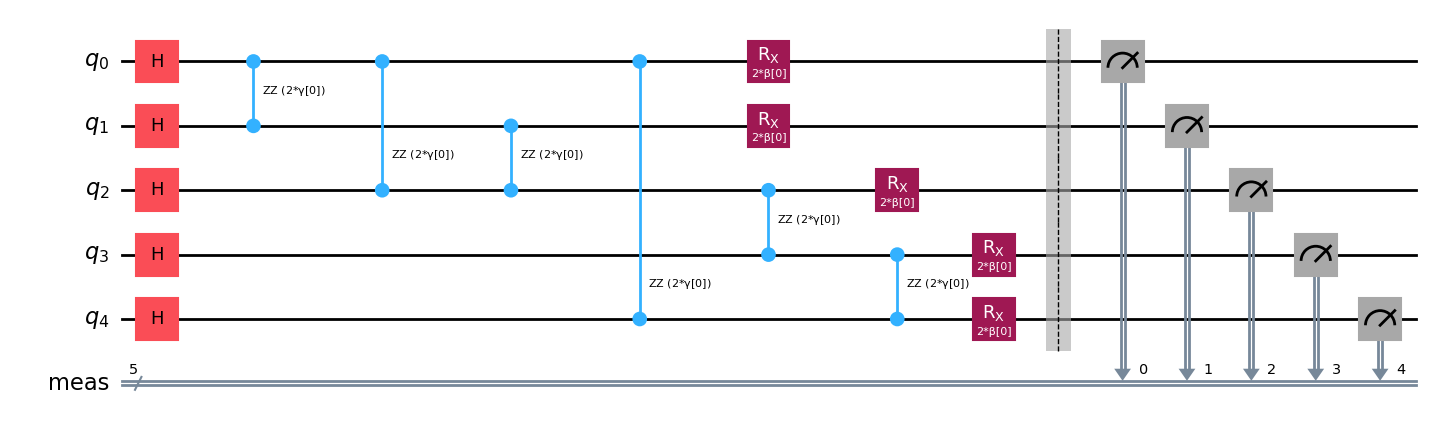

In [ ]:
p = 1
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()
candidate_circuit = transpile(circuit, backend=AerSimulator(), optimization_level=3)
candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta] * p + [initial_gamma] * p

objective_func_vals = []

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    job = estimator.run(
        circuits=[ansatz],
        observables=[hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost

estimator = Estimator()

result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.087890625
       x: [ 3.335e-01  2.797e+00]
    nfev: 17
   maxcv: 0.0


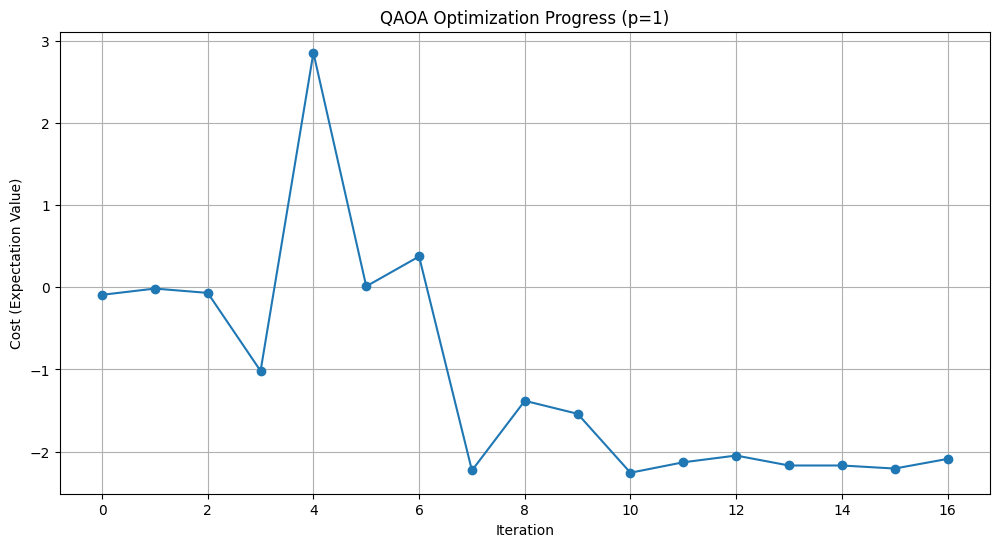

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Cost (Expectation Value)")
plt.title(f"QAOA Optimization Progress (p={p})")
plt.grid(True)
plt.show()

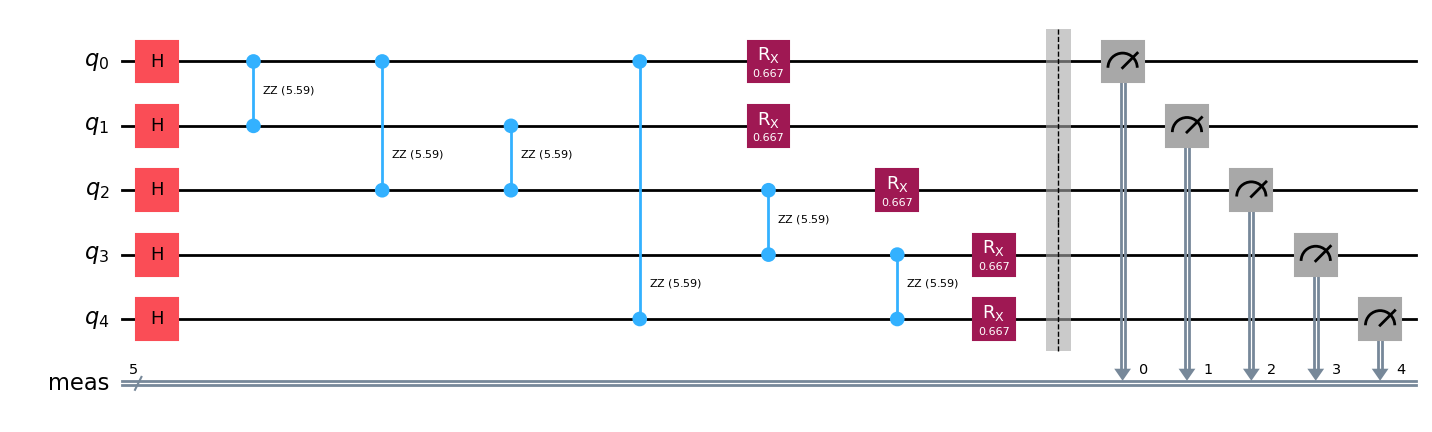

In [ ]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
sampler = Sampler()
job = sampler.run([optimized_circuit], shots=10_000)
res = job.result()

quasi_dist = res.quasi_dists[0]
final_distribution_int = {}
for k, v in quasi_dist.items():
    if isinstance(k, str):
        final_distribution_int[int(k, 2)] = float(v)
    else:
        final_distribution_int[k] = float(v)

print(final_distribution_int)

{2: 0.0007, 29: 0.0006, 7: 0.0039, 26: 0.0714, 5: 0.0689, 9: 0.1027, 17: 0.0318, 13: 0.0464, 19: 0.0313, 18: 0.0449, 28: 0.0187, 21: 0.0489, 6: 0.0184, 1: 0.0072, 22: 0.1086, 3: 0.0178, 11: 0.1036, 23: 0.0024, 20: 0.1026, 10: 0.0478, 8: 0.0022, 12: 0.0306, 16: 0.0025, 25: 0.021, 0: 0.005, 14: 0.0275, 30: 0.0063, 4: 0.0072, 27: 0.0078, 31: 0.0047, 24: 0.0049, 15: 0.0017}


In [ ]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(values)]

most_likely_bitstring = to_bitstring(most_likely, n)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 1, 0, 1]


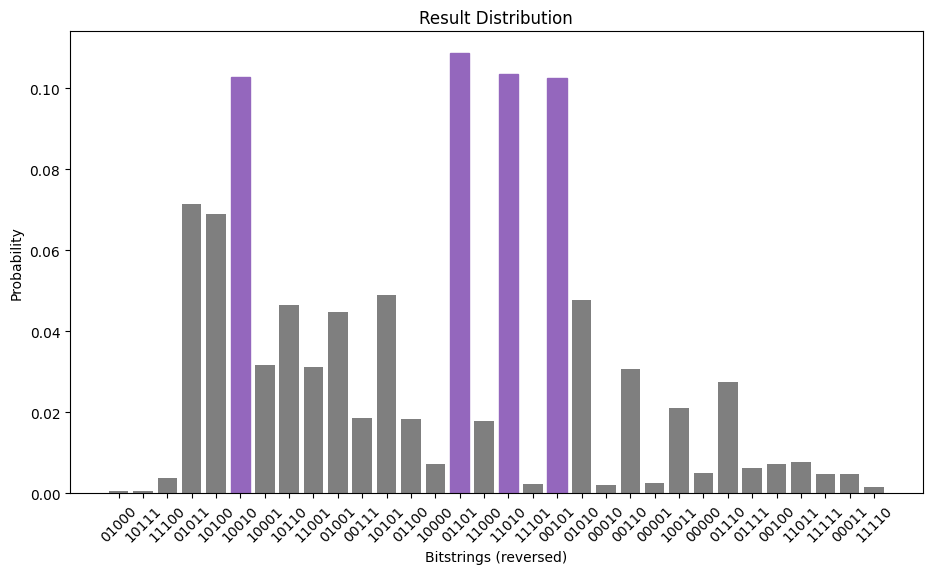

In [ ]:
import matplotlib
matplotlib.rcParams.update({"font.size": 10})

bitstring_labels = [''.join(map(str, to_bitstring(k, n)[::-1])) for k in keys]
top_4_values = sorted(values, reverse=True)[:4]
positions = [np.where(np.isclose(values, v))[0][0] for v in top_4_values]

fig, ax = plt.subplots(figsize=(11, 6))
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(bitstring_labels, values, color="tab:grey")
for p_ in positions:
    bars[p_].set_color("tab:purple")

plt.show()

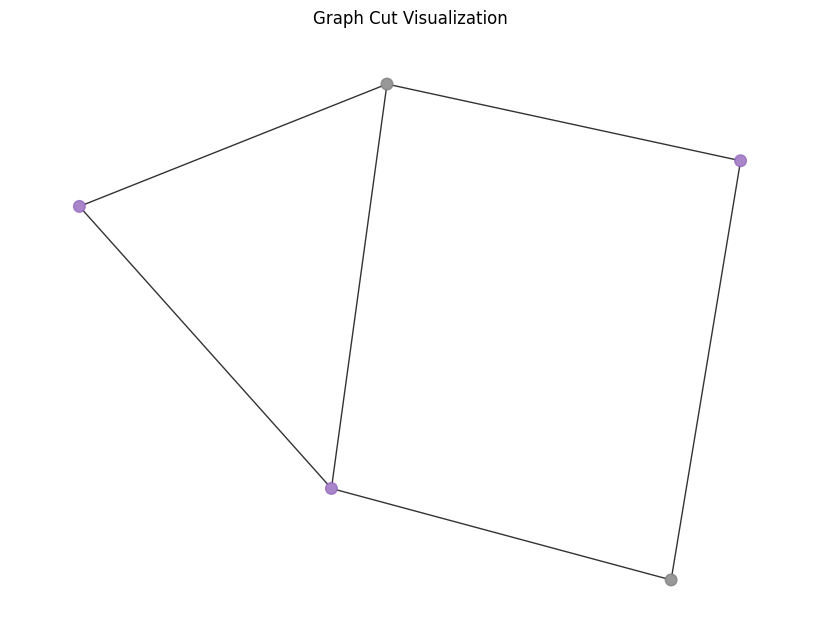

In [ ]:
def plot_result(G: rx.PyGraph, x: Sequence[int]):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title("Graph Cut Visualization")
    plt.show()

plot_result(graph, most_likely_bitstring)

In [ ]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "Length mismatch"
    cut_value = 0
    for u, v in graph.edge_list():
        cut_value += x[u] * (1 - x[v]) + x[v] * (1 - x[u])
    return cut_value

cut_val = evaluate_sample(most_likely_bitstring, graph)
print(f"The value of the cut is: {cut_val}")

The value of the cut is: 5


## depth = 2

In [ ]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from typing import Sequence

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler

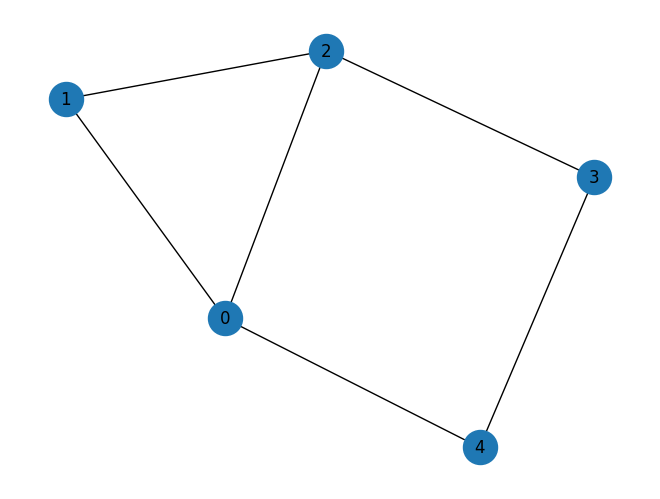

In [ ]:
n = 5
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(n))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [ ]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, list[int], float]]:
    pauli_list = []
    for u, v in graph.edge_list():
        weight = graph.get_edge_data(u, v)
        pauli_list.append(("ZZ", [u, v], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, num_qubits=n)
print("Cost Function Hamiltonian:\n", cost_hamiltonian)

Cost Function Hamiltonian:
 SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


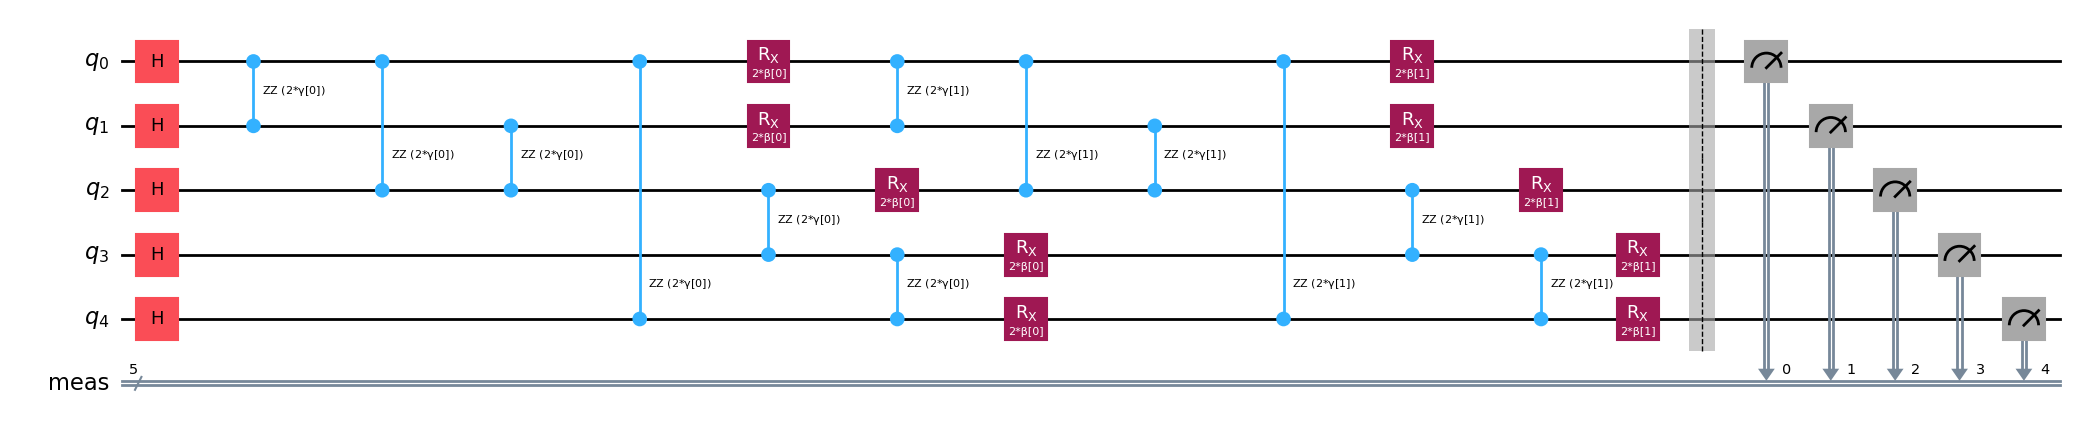

In [ ]:
p = 2
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()
candidate_circuit = transpile(circuit, backend=AerSimulator(), optimization_level=3)
candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta] * p + [initial_gamma] * p

objective_func_vals = []

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    job = estimator.run(
        circuits=[ansatz],
        observables=[hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost

estimator = Estimator()

result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.21484375
       x: [ 1.909e+00  1.714e+00  2.742e+00  4.622e+00]
    nfev: 30
   maxcv: 0.0


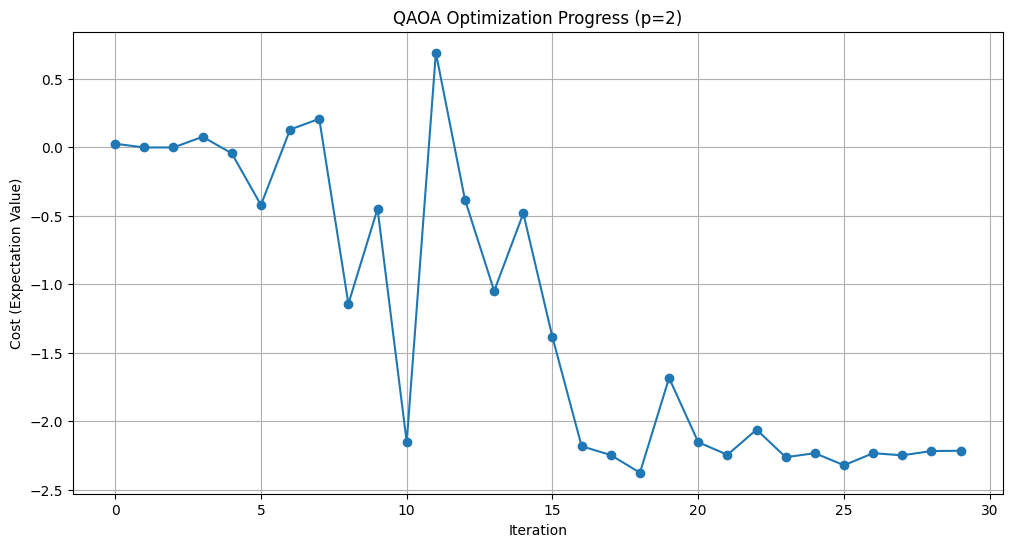

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Cost (Expectation Value)")
plt.title(f"QAOA Optimization Progress (p={p})")
plt.grid(True)
plt.show()

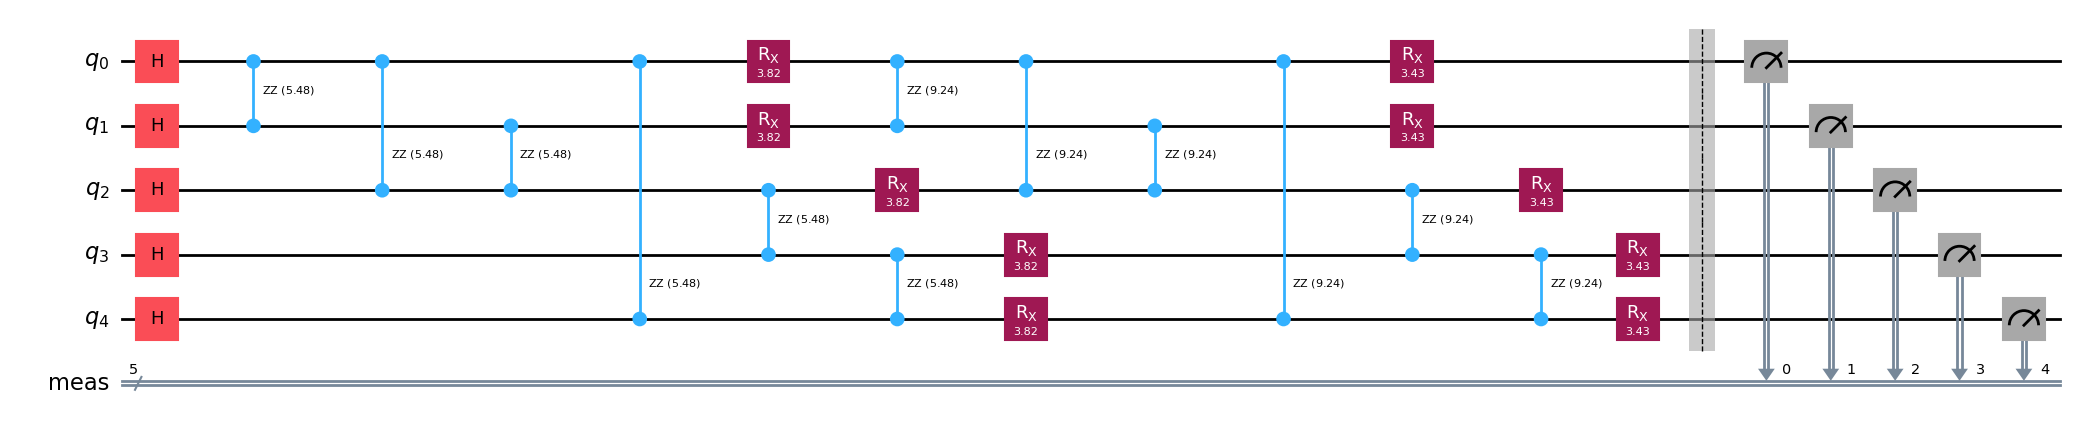

In [ ]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
sampler = Sampler()
job = sampler.run([optimized_circuit], shots=10_000)
res = job.result()

quasi_dist = res.quasi_dists[0]
final_distribution_int = {}
for k, v in quasi_dist.items():
    if isinstance(k, str):
        final_distribution_int[int(k, 2)] = float(v)
    else:
        final_distribution_int[k] = float(v)

print(final_distribution_int)

{30: 0.0071, 7: 0.0045, 10: 0.0433, 26: 0.0893, 9: 0.1047, 5: 0.0872, 17: 0.0371, 22: 0.1052, 29: 0.008, 21: 0.0434, 18: 0.0443, 28: 0.0047, 6: 0.0058, 1: 0.0059, 11: 0.1019, 23: 0.0023, 20: 0.1046, 8: 0.0028, 12: 0.0356, 14: 0.0348, 13: 0.0457, 19: 0.0379, 31: 0.0021, 27: 0.0057, 16: 0.0035, 4: 0.0046, 3: 0.0052, 2: 0.0078, 24: 0.0047, 15: 0.0035, 0: 0.0023, 25: 0.0045}


In [ ]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(values)]

most_likely_bitstring = to_bitstring(most_likely, n)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 1, 0, 1]


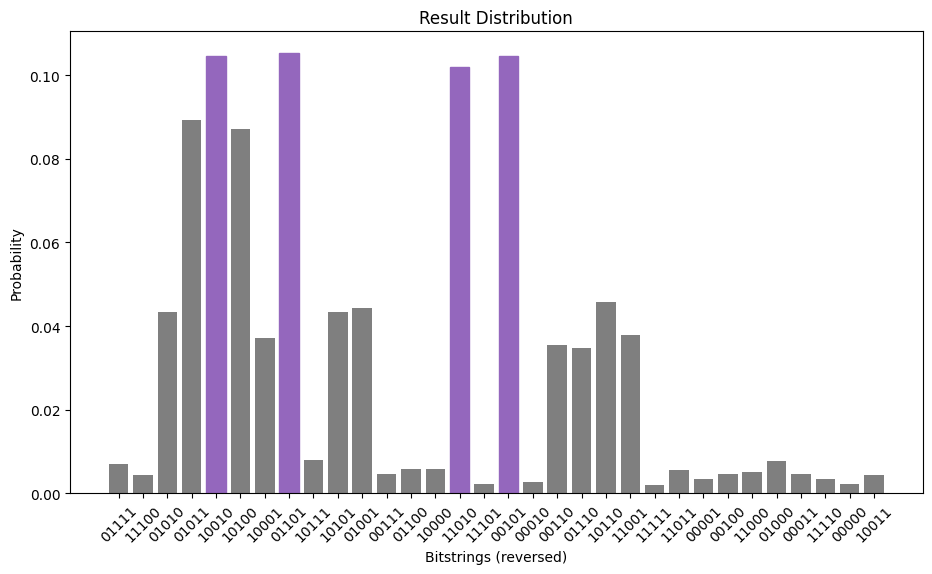

In [ ]:
import matplotlib
matplotlib.rcParams.update({"font.size": 10})

bitstring_labels = [''.join(map(str, to_bitstring(k, n)[::-1])) for k in keys]
top_4_values = sorted(values, reverse=True)[:4]
positions = [np.where(np.isclose(values, v))[0][0] for v in top_4_values]

fig, ax = plt.subplots(figsize=(11, 6))
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(bitstring_labels, values, color="tab:grey")
for p_ in positions:
    bars[p_].set_color("tab:purple")

plt.show()

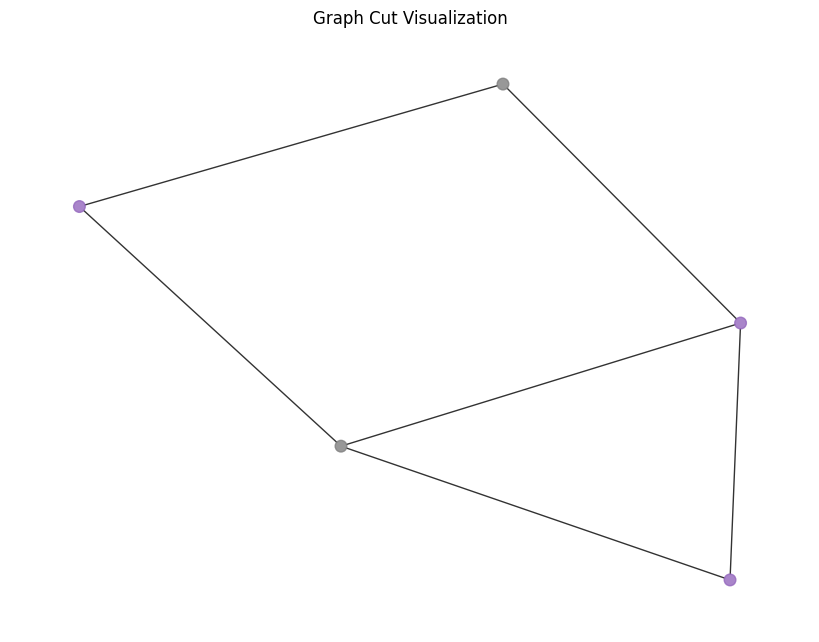

In [ ]:
def plot_result(G: rx.PyGraph, x: Sequence[int]):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title("Graph Cut Visualization")
    plt.show()

plot_result(graph, most_likely_bitstring)

In [ ]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "Length mismatch"
    cut_value = 0
    for u, v in graph.edge_list():
        cut_value += x[u] * (1 - x[v]) + x[v] * (1 - x[u])
    return cut_value

cut_val = evaluate_sample(most_likely_bitstring, graph)
print(f"The value of the cut is: {cut_val}")

The value of the cut is: 5


## depth = 3

In [ ]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from typing import Sequence

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler

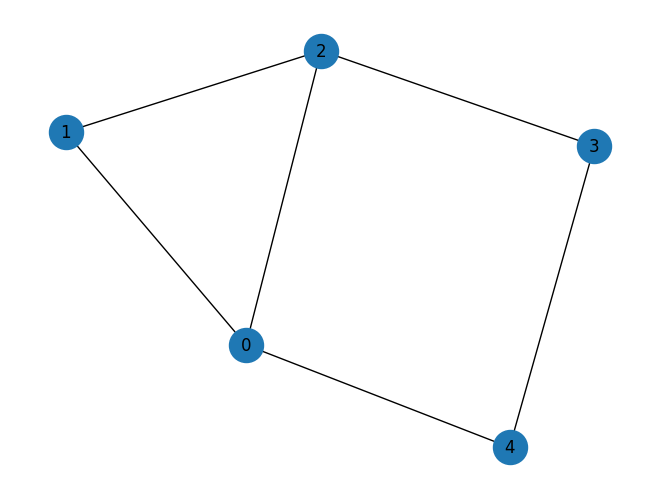

In [ ]:
n = 5
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(n))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [ ]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, list[int], float]]:
    pauli_list = []
    for u, v in graph.edge_list():
        weight = graph.get_edge_data(u, v)
        pauli_list.append(("ZZ", [u, v], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, num_qubits=n)
print("Cost Function Hamiltonian:\n", cost_hamiltonian)

Cost Function Hamiltonian:
 SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


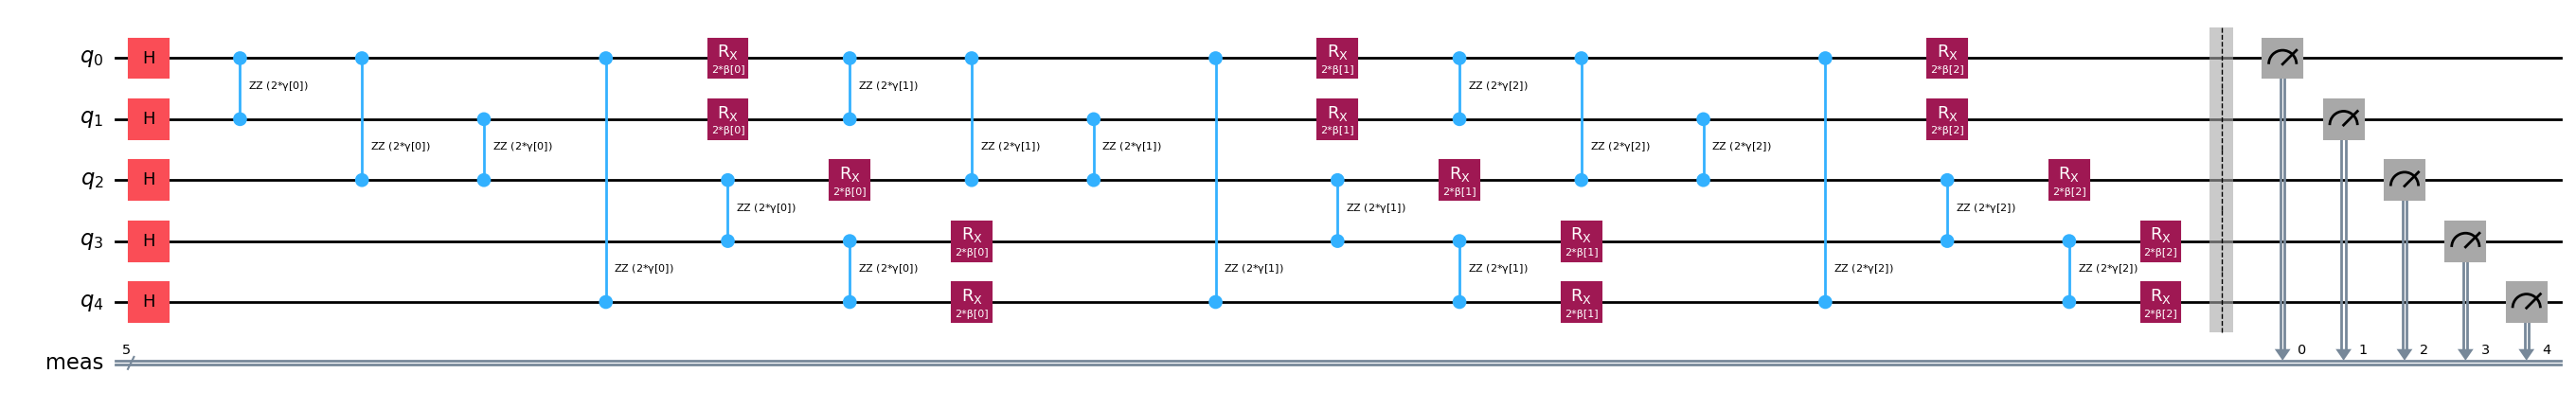

In [ ]:
p = 3
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()
candidate_circuit = transpile(circuit, backend=AerSimulator(), optimization_level=3)
candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta] * p + [initial_gamma] * p

objective_func_vals = []

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    job = estimator.run(
        circuits=[ansatz],
        observables=[hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost

estimator = Estimator()

result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.259765625
       x: [ 3.070e+00  1.795e+00  1.173e+00  4.359e+00  2.870e+00
            2.541e+00]
    nfev: 48
   maxcv: 0.0


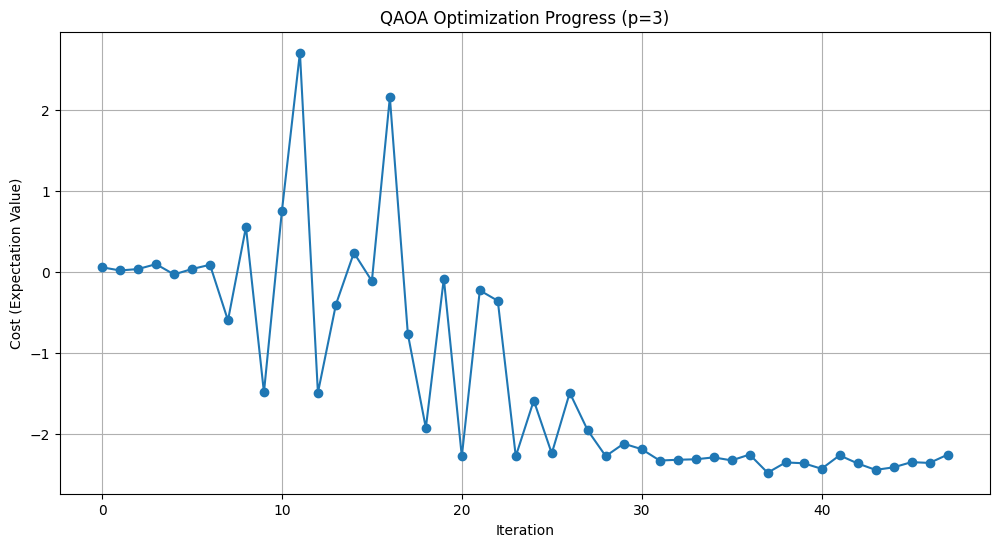

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Cost (Expectation Value)")
plt.title(f"QAOA Optimization Progress (p={p})")
plt.grid(True)
plt.show()

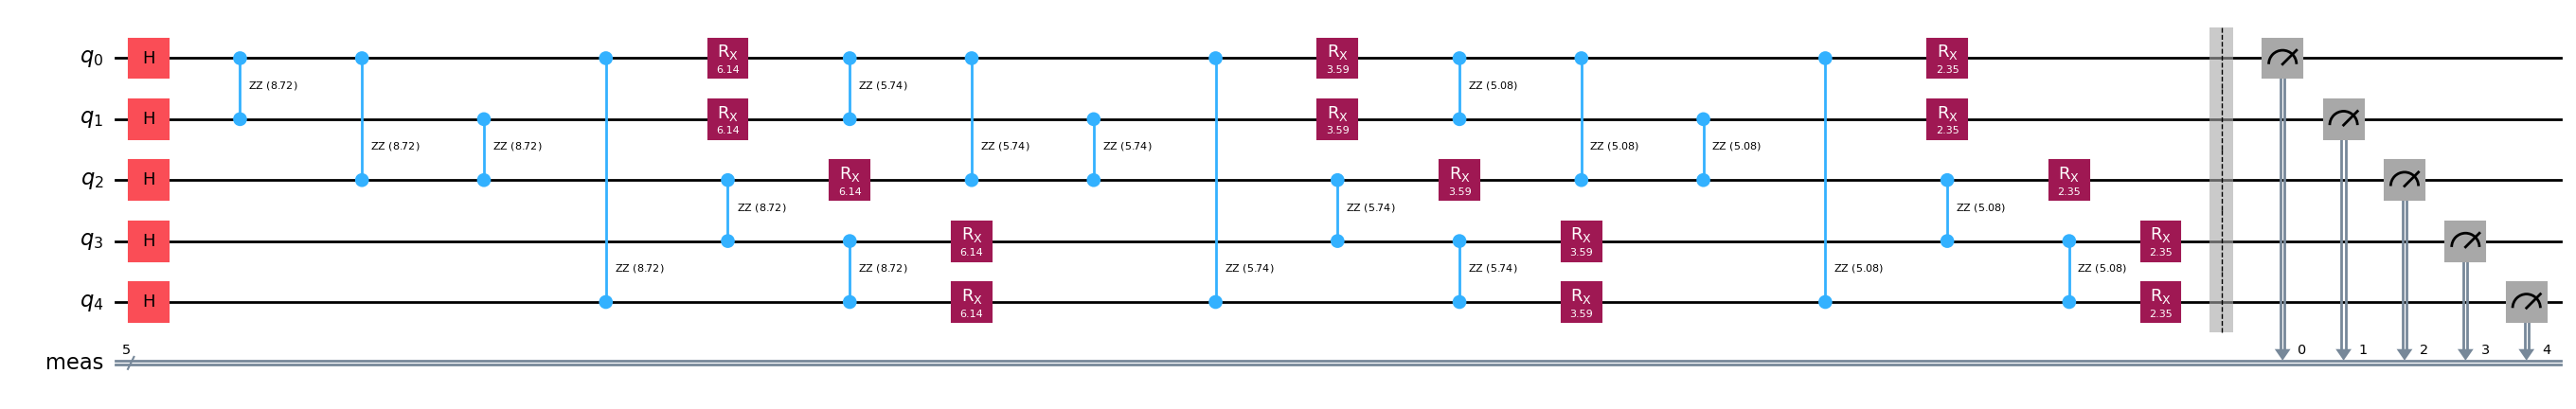

In [ ]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
sampler = Sampler()
job = sampler.run([optimized_circuit], shots=10_000)
res = job.result()

quasi_dist = res.quasi_dists[0]
final_distribution_int = {}
for k, v in quasi_dist.items():
    if isinstance(k, str):
        final_distribution_int[int(k, 2)] = float(v)
    else:
        final_distribution_int[k] = float(v)

print(final_distribution_int)

{29: 0.0065, 9: 0.1091, 5: 0.0663, 17: 0.0043, 26: 0.0666, 30: 0.0022, 22: 0.1078, 18: 0.0672, 21: 0.0676, 28: 0.0148, 10: 0.0694, 7: 0.0074, 3: 0.0138, 11: 0.1098, 23: 0.0068, 20: 0.111, 1: 0.0029, 6: 0.0127, 13: 0.0701, 27: 0.0024, 31: 0.0055, 24: 0.0084, 8: 0.0069, 12: 0.0057, 4: 0.0037, 0: 0.0057, 25: 0.0123, 2: 0.0061, 19: 0.0048, 15: 0.0084, 14: 0.0065, 16: 0.0073}


In [ ]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(values)]

most_likely_bitstring = to_bitstring(most_likely, n)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 0, 1, 0, 1]


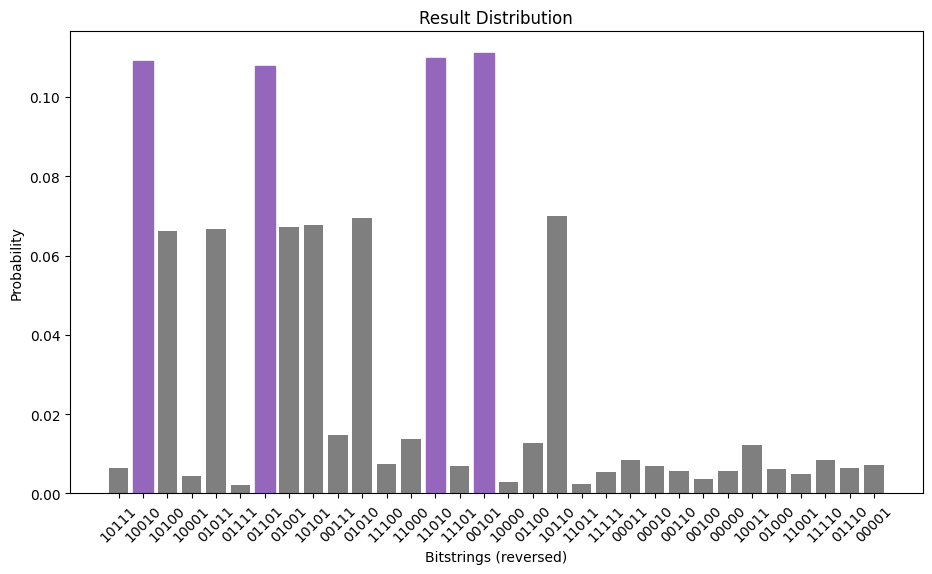

In [ ]:
import matplotlib
matplotlib.rcParams.update({"font.size": 10})

bitstring_labels = [''.join(map(str, to_bitstring(k, n)[::-1])) for k in keys]
top_4_values = sorted(values, reverse=True)[:4]
positions = [np.where(np.isclose(values, v))[0][0] for v in top_4_values]

fig, ax = plt.subplots(figsize=(11, 6))
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(bitstring_labels, values, color="tab:grey")
for p_ in positions:
    bars[p_].set_color("tab:purple")

plt.show()

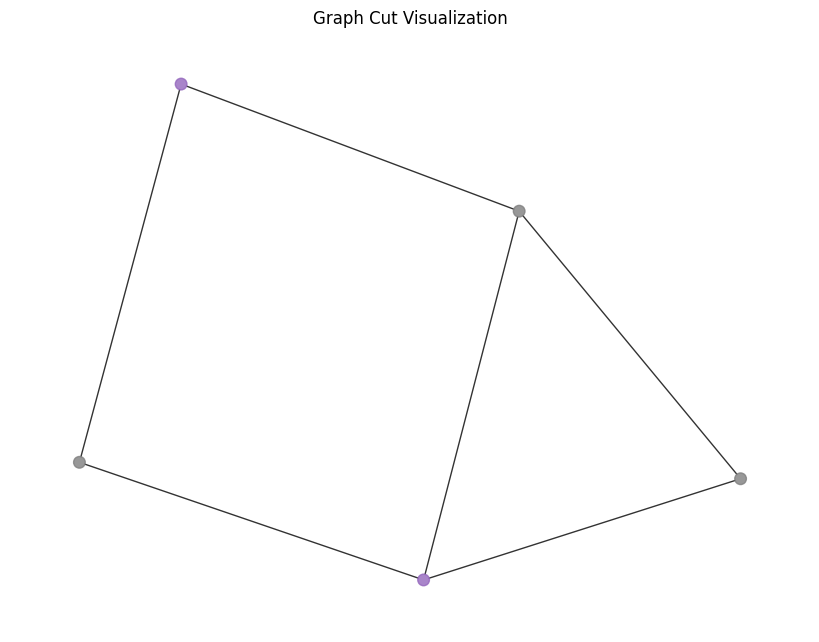

In [ ]:
def plot_result(G: rx.PyGraph, x: Sequence[int]):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title("Graph Cut Visualization")
    plt.show()

plot_result(graph, most_likely_bitstring)

In [ ]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "Length mismatch"
    cut_value = 0
    for u, v in graph.edge_list():
        cut_value += x[u] * (1 - x[v]) + x[v] * (1 - x[u])
    return cut_value

cut_val = evaluate_sample(most_likely_bitstring, graph)
print(f"The value of the cut is: {cut_val}")

The value of the cut is: 5


# Node 10

## depth = 1

In [ ]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from typing import Sequence

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler

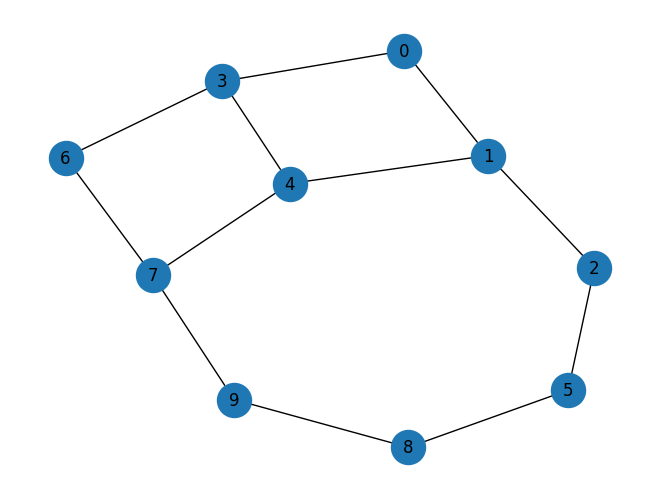

In [ ]:
n = 10
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(n))

edge_list = [
    (0, 1, 1.0),
    (0, 3, 1.0),
    (1, 2, 1.0),
    (1, 4, 1.0),
    (2, 5, 1.0),
    (3, 4, 1.0),
    (3, 6, 1.0),
    (4, 7, 1.0),
    (5, 8, 1.0),
    (6, 7, 1.0),
    (7, 9, 1.0),
    (8, 9, 1.0),
]

graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [ ]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, list[int], float]]:
    pauli_list = []
    for u, v in graph.edge_list():
        weight = graph.get_edge_data(u, v)
        pauli_list.append(("ZZ", [u, v], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, num_qubits=n)
print("Cost Function Hamiltonian:\n", cost_hamiltonian)

Cost Function Hamiltonian:
 SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIZIIZ', 'IIIIIIIZZI', 'IIIIIZIIZI', 'IIIIZIIZII', 'IIIIIZZIII', 'IIIZIIZIII', 'IIZIIZIIII', 'IZIIZIIIII', 'IIZZIIIIII', 'ZIZIIIIIII', 'ZZIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j])


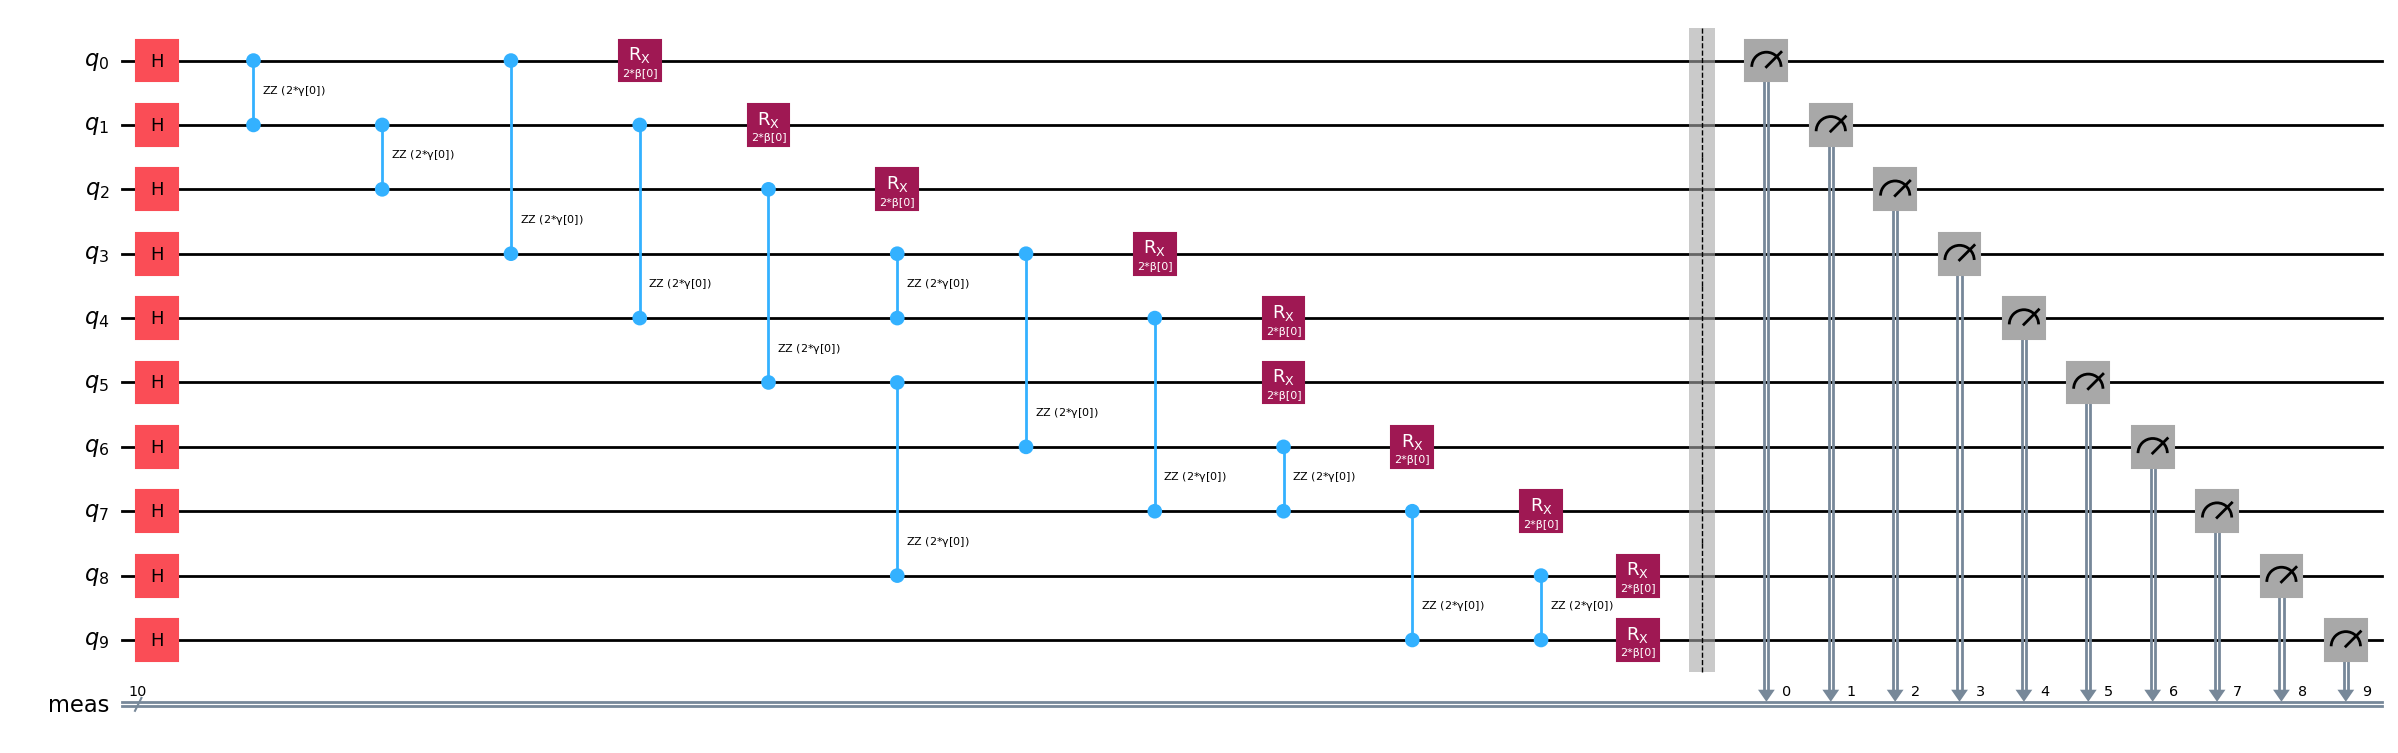

In [ ]:
p = 1
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()
candidate_circuit = transpile(circuit, backend=AerSimulator(), optimization_level=3)
candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta] * p + [initial_gamma] * p

objective_func_vals = []

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    job = estimator.run(
        circuits=[ansatz],
        observables=[hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost

estimator = Estimator()

result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.369140625
       x: [ 2.686e+00  2.097e+00]
    nfev: 18
   maxcv: 0.0


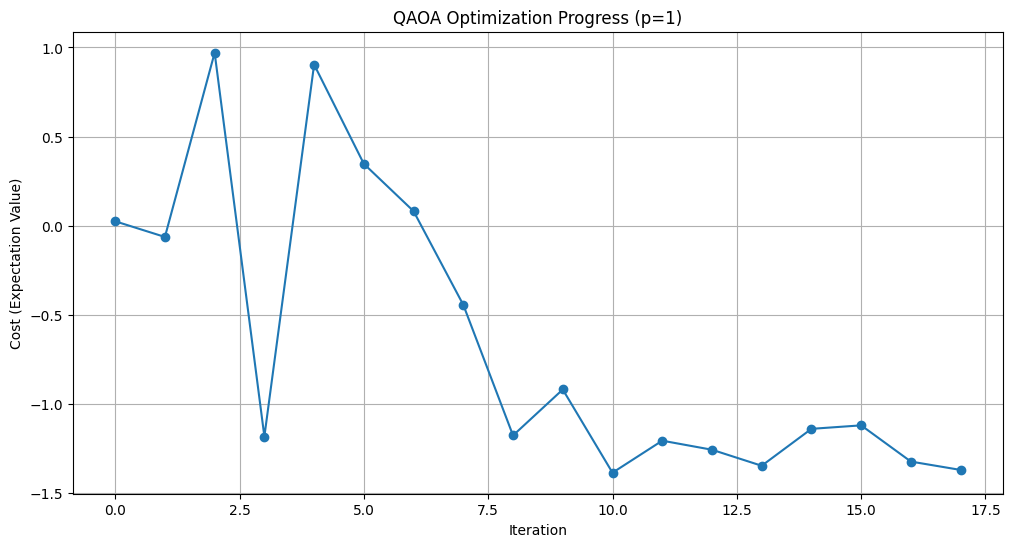

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Cost (Expectation Value)")
plt.title(f"QAOA Optimization Progress (p={p})")
plt.grid(True)
plt.show()

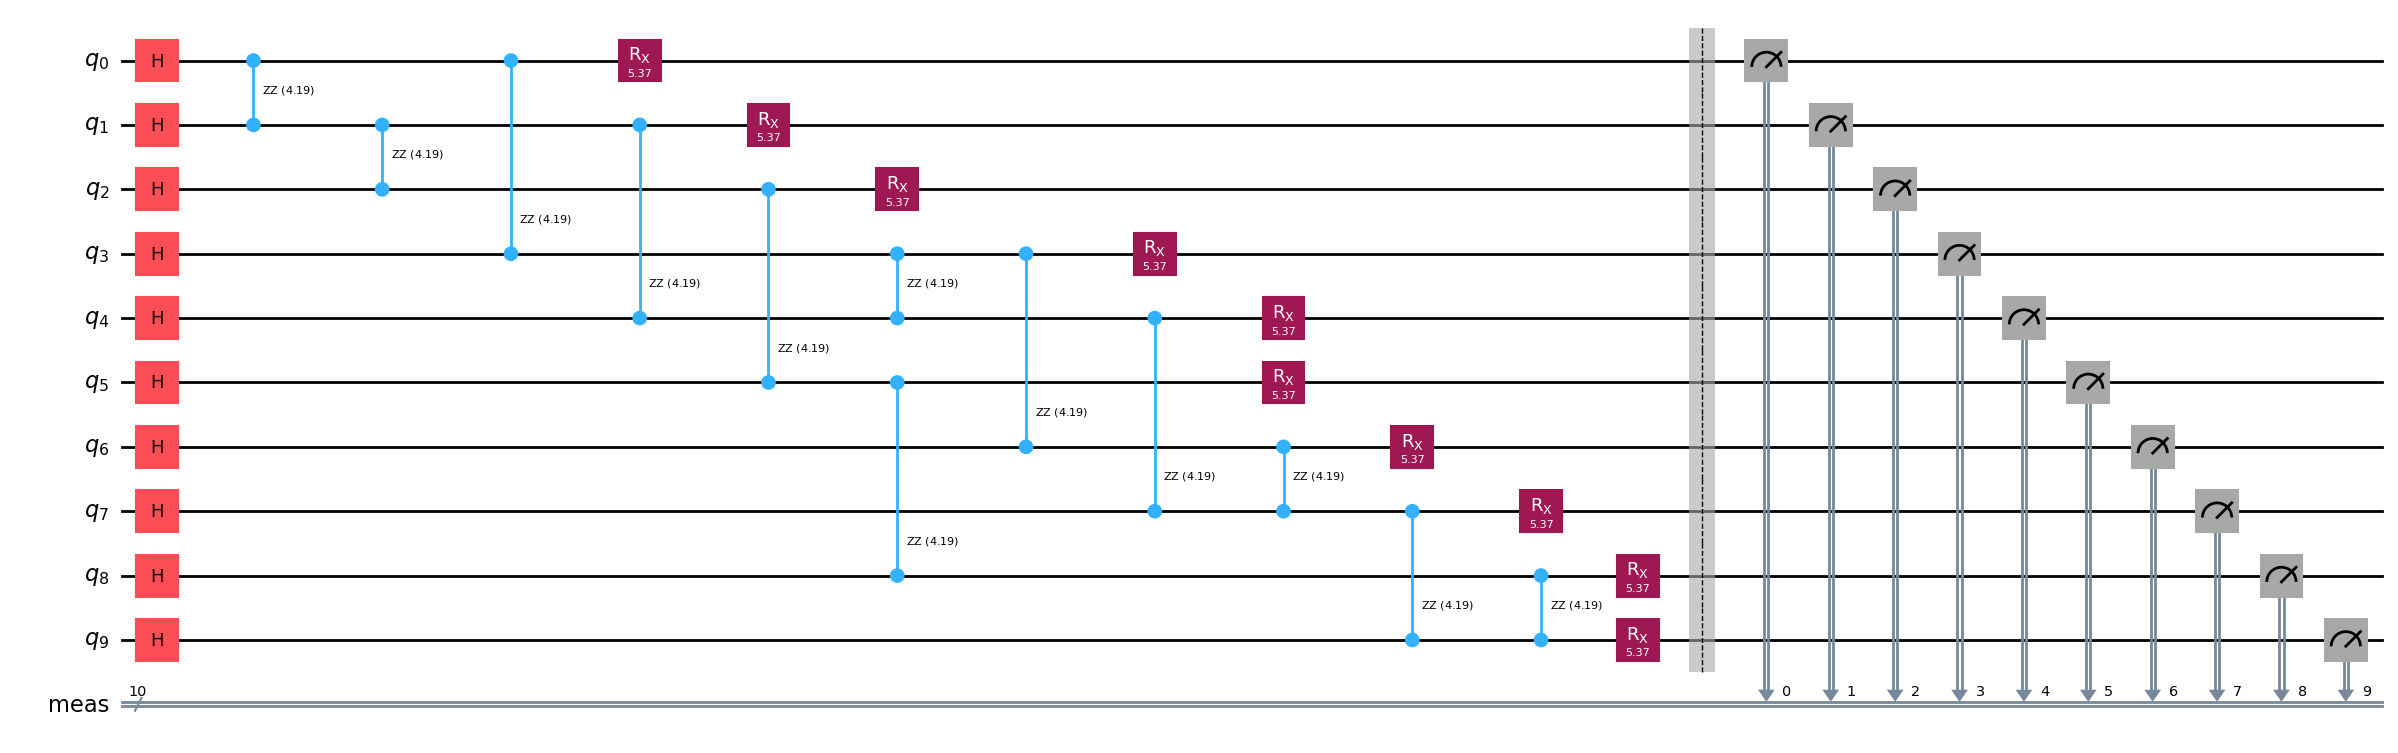

In [ ]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
sampler = Sampler()
job = sampler.run([optimized_circuit], shots=10_000)
res = job.result()

quasi_dist = res.quasi_dists[0]
final_distribution_int = {}
for k, v in quasi_dist.items():
    if isinstance(k, str):
        final_distribution_int[int(k, 2)] = float(v)
    else:
        final_distribution_int[k] = float(v)

print(final_distribution_int)

{988: 0.0001, 1013: 0.0003, 328: 0.0002, 448: 0.0002, 318: 0.0001, 18: 0.0001, 750: 0.0001, 951: 0.0001, 88: 0.0001, 136: 0.0004, 139: 0.0001, 108: 0.0001, 922: 0.0007, 956: 0.0002, 825: 0.0001, 536: 0.0001, 998: 0.0002, 995: 0.0001, 921: 0.0002, 579: 0.0004, 574: 0.0006, 1014: 0.0001, 523: 0.0001, 520: 0.0003, 768: 0.0001, 902: 0.0002, 872: 0.0003, 649: 0.0001, 657: 0.0001, 301: 0.0002, 137: 0.0002, 932: 0.0002, 19: 0.0001, 915: 0.0002, 733: 0.0001, 651: 0.0001, 193: 0.0001, 898: 0.0001, 319: 0.0002, 724: 0.0001, 904: 0.0001, 771: 0.0001, 875: 0.0001, 138: 0.0001, 977: 0.0001, 309: 0.0001, 949: 0.0001, 1022: 0.0001, 704: 0.0001, 539: 0.0001, 942: 0.0002, 462: 0.0001, 236: 0.0001, 850: 0.0001, 931: 0.0002, 976: 0.0002, 1006: 0.0001, 648: 0.0002, 791: 0.0002, 383: 0.0001, 888: 0.0002, 1021: 0.0001, 997: 0.0001, 281: 0.0004, 146: 0.0001, 802: 0.0002, 500: 0.0001, 112: 0.0001, 865: 0.0003, 877: 0.0001, 459: 0.0003, 819: 0.0001, 537: 0.0003, 601: 0.0004, 457: 0.0006, 533: 0.0001, 473: 0.00

In [ ]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(values)]

most_likely_bitstring = to_bitstring(most_likely, n)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 1, 1, 1, 0, 0, 1, 1, 0]


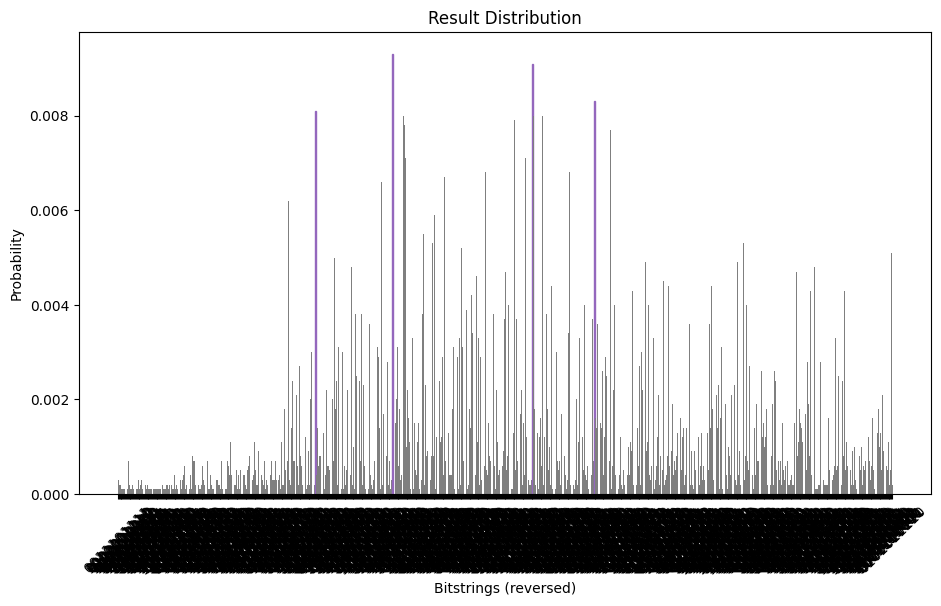

In [ ]:
import matplotlib
matplotlib.rcParams.update({"font.size": 10})

bitstring_labels = [''.join(map(str, to_bitstring(k, n)[::-1])) for k in keys]
top_4_values = sorted(values, reverse=True)[:4]
positions = [np.where(np.isclose(values, v))[0][0] for v in top_4_values]

fig, ax = plt.subplots(figsize=(11, 6))
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(bitstring_labels, values, color="tab:grey")
for p_ in positions:
    bars[p_].set_color("tab:purple")

plt.show()

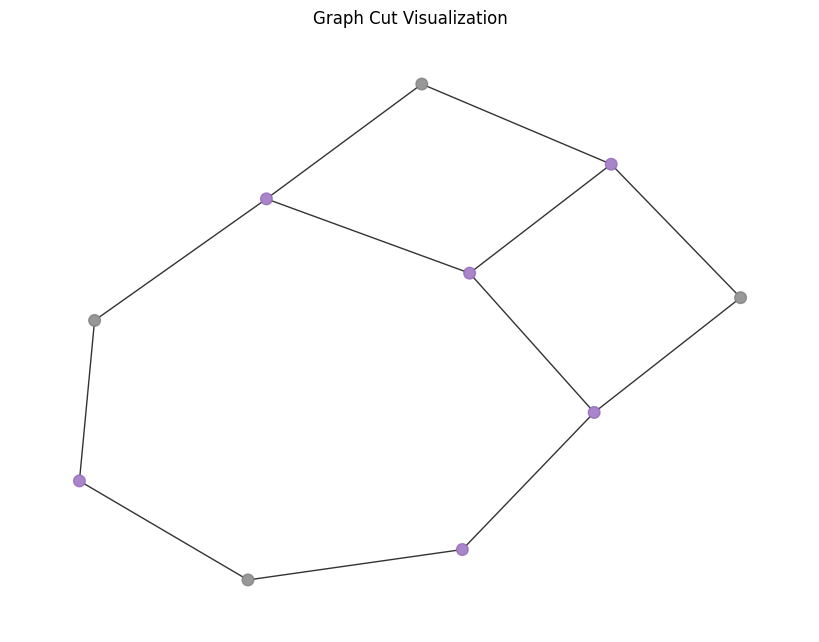

In [ ]:
def plot_result(G: rx.PyGraph, x: Sequence[int]):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title("Graph Cut Visualization")
    plt.show()

plot_result(graph, most_likely_bitstring)

In [ ]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "Length mismatch"
    cut_value = 0
    for u, v in graph.edge_list():
        cut_value += x[u] * (1 - x[v]) + x[v] * (1 - x[u])
    return cut_value

cut_val = evaluate_sample(most_likely_bitstring, graph)
print(f"The value of the cut is: {cut_val}")

The value of the cut is: 8


## depth = 2

In [ ]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from typing import Sequence

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler

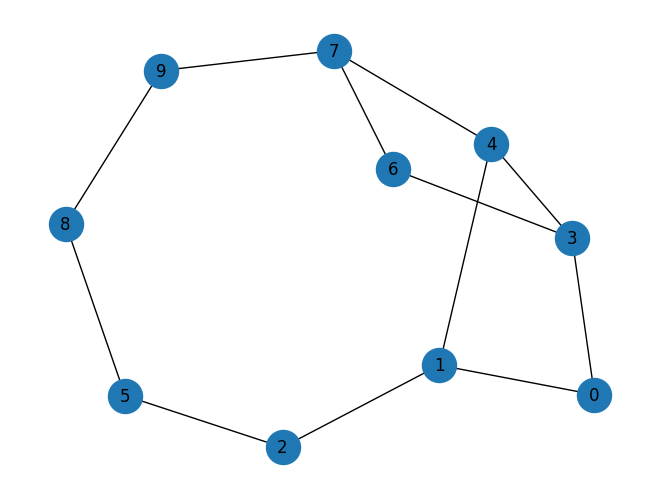

In [ ]:
import numpy as np
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

n = 10
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(n))

edge_list = [
    (0, 1, 1.0),
    (0, 3, 1.0),
    (1, 2, 1.0),
    (1, 4, 1.0),
    (2, 5, 1.0),
    (3, 4, 1.0),
    (3, 6, 1.0),
    (4, 7, 1.0),
    (5, 8, 1.0),
    (6, 7, 1.0),
    (7, 9, 1.0),
    (8, 9, 1.0),
]

graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [ ]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, list[int], float]]:
    pauli_list = []
    for u, v in graph.edge_list():
        weight = graph.get_edge_data(u, v)
        pauli_list.append(("ZZ", [u, v], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, num_qubits=n)
print("Cost Function Hamiltonian:\n", cost_hamiltonian)

Cost Function Hamiltonian:
 SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIZIIZ', 'IIIIIIIZZI', 'IIIIIZIIZI', 'IIIIZIIZII', 'IIIIIZZIII', 'IIIZIIZIII', 'IIZIIZIIII', 'IZIIZIIIII', 'IIZZIIIIII', 'ZIZIIIIIII', 'ZZIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j])


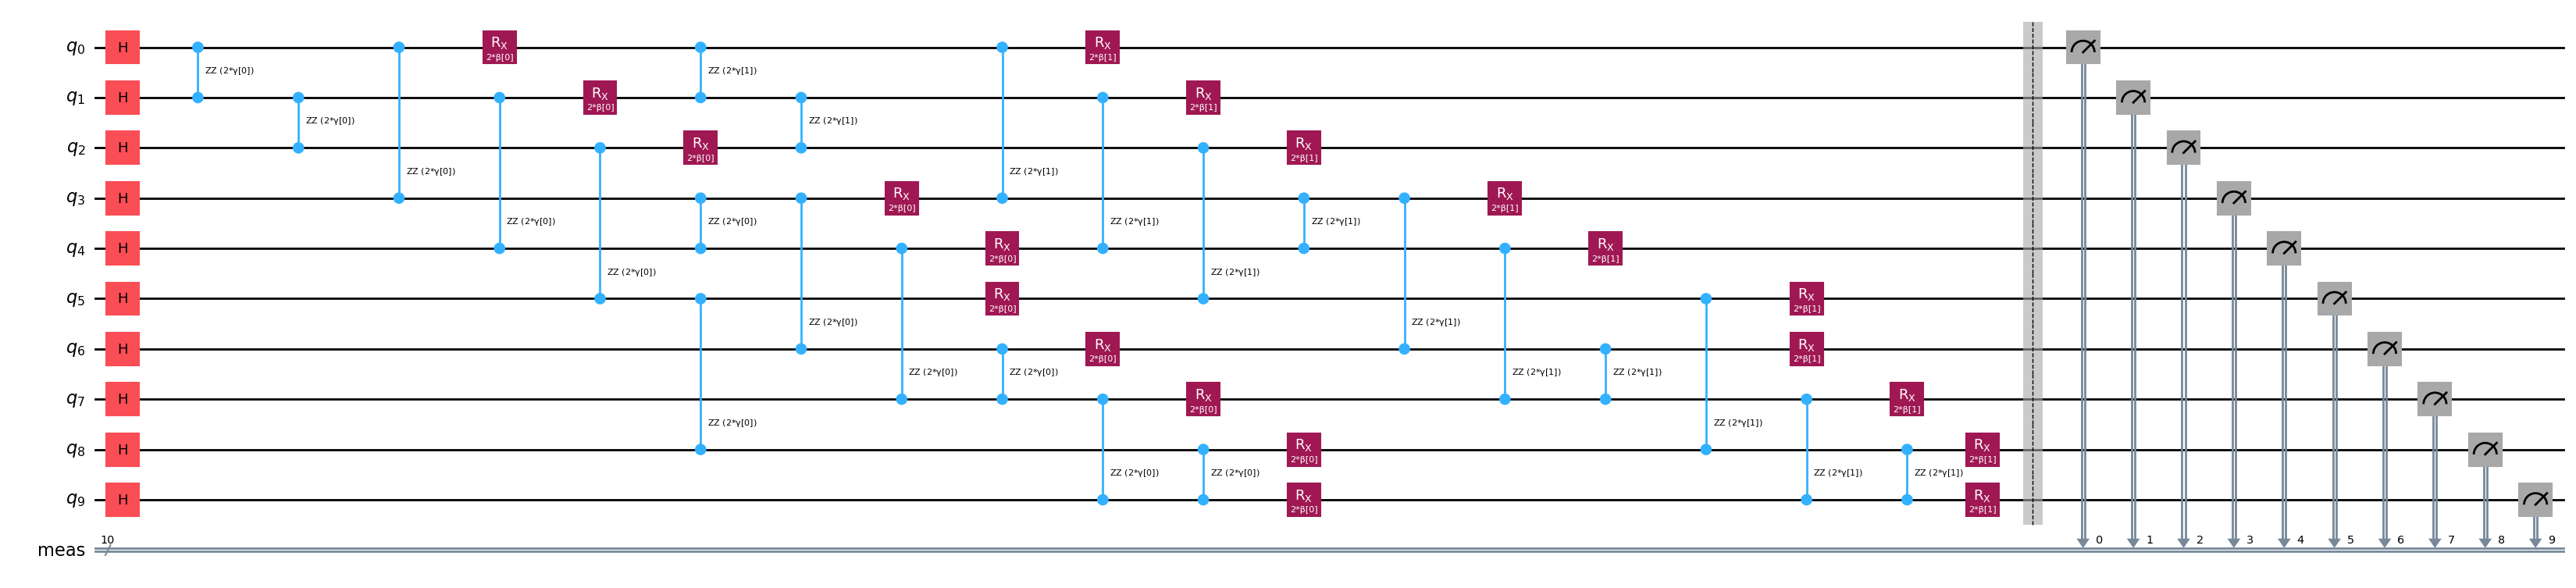

In [ ]:
p = 2
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()
candidate_circuit = transpile(circuit, backend=AerSimulator(), optimization_level=3)
candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta] * p + [initial_gamma] * p

objective_func_vals = []

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    job = estimator.run(
        circuits=[ansatz],
        observables=[hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost

estimator = Estimator()

result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.44140625
       x: [ 2.594e+00  2.638e+00  4.250e+00  3.403e+00]
    nfev: 26
   maxcv: 0.0


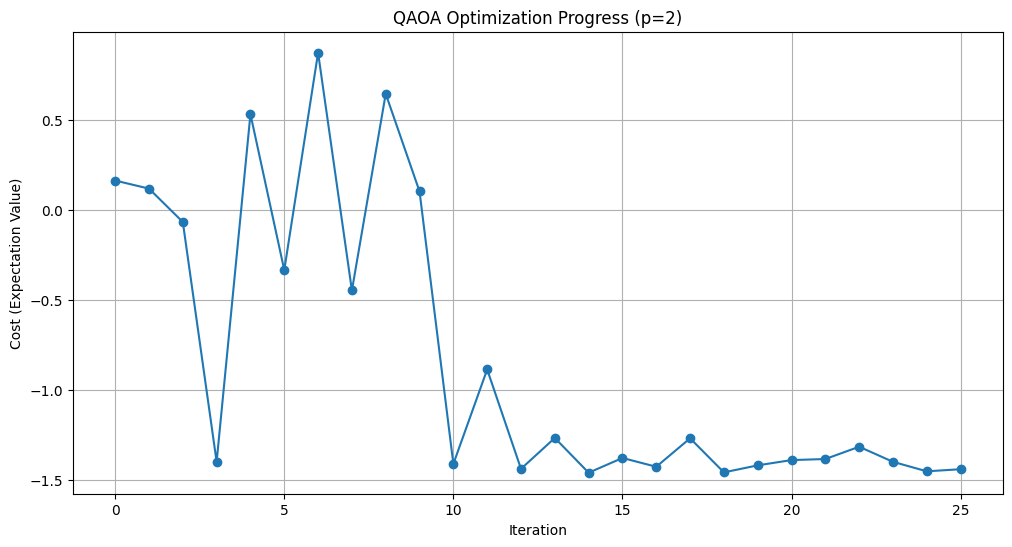

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Cost (Expectation Value)")
plt.title(f"QAOA Optimization Progress (p={p})")
plt.grid(True)
plt.show()

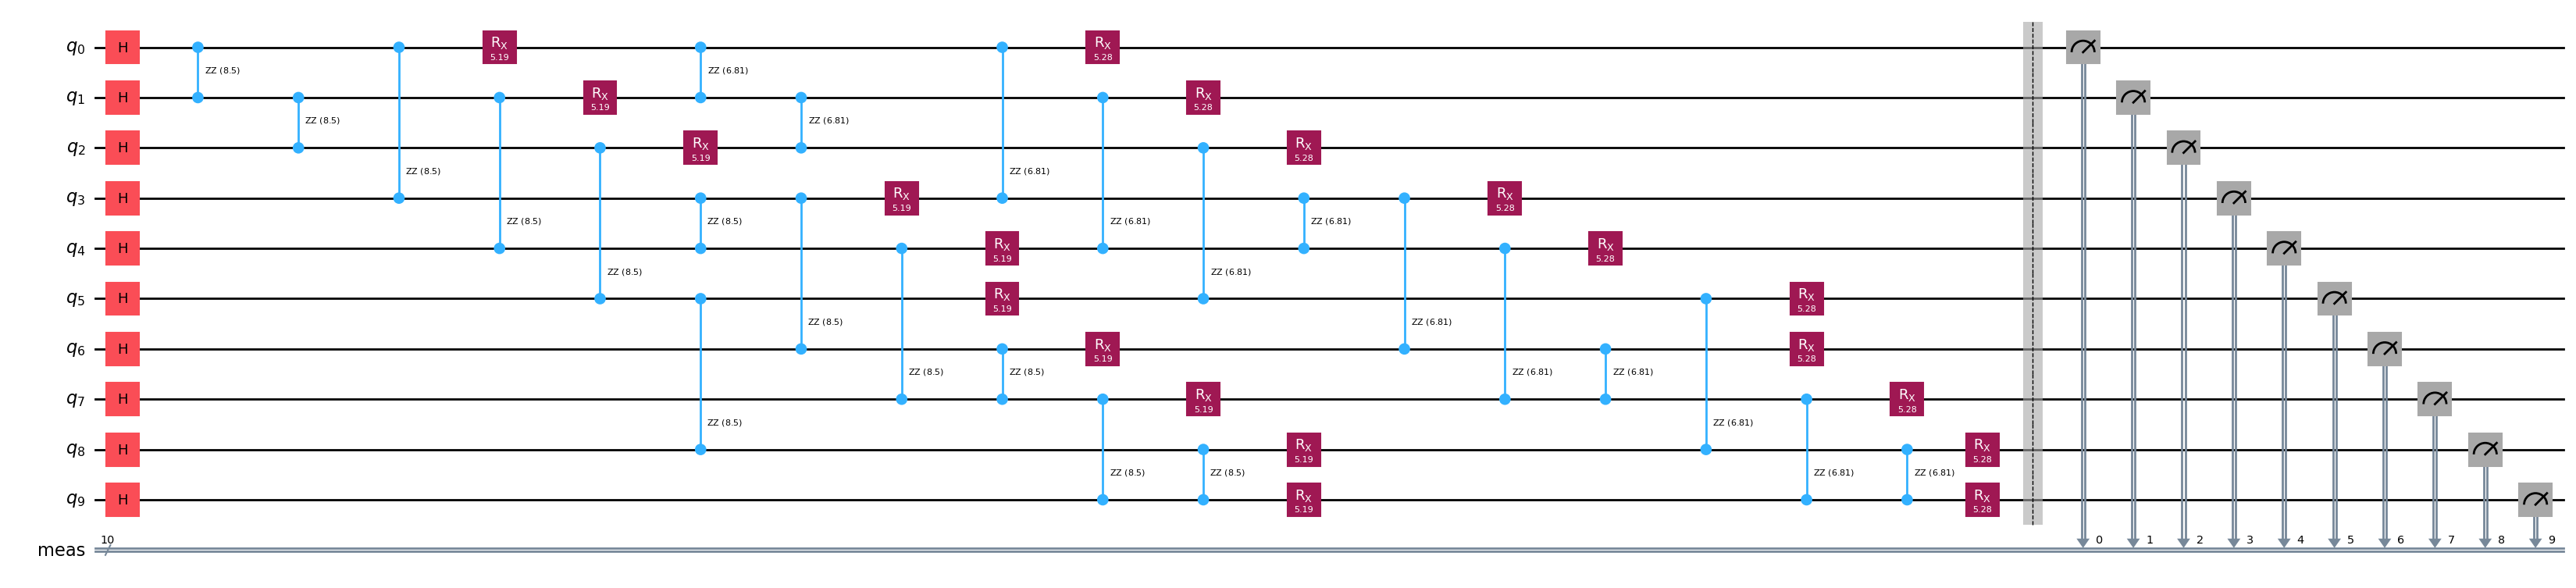

In [ ]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
sampler = Sampler()
job = sampler.run([optimized_circuit], shots=10_000)
res = job.result()

quasi_dist = res.quasi_dists[0]
final_distribution_int = {}
for k, v in quasi_dist.items():
    if isinstance(k, str):
        final_distribution_int[int(k, 2)] = float(v)
    else:
        final_distribution_int[k] = float(v)

print(final_distribution_int)

{20: 0.0001, 296: 0.0001, 1013: 0.0001, 772: 0.0001, 373: 0.0002, 530: 0.0001, 578: 0.0004, 897: 0.0002, 444: 0.0003, 221: 0.0001, 922: 0.0004, 800: 0.0001, 929: 0.0003, 600: 0.0001, 650: 0.0001, 206: 0.0001, 376: 0.0002, 4: 0.0002, 153: 0.0001, 651: 0.0002, 264: 0.0002, 92: 0.0001, 1022: 0.0001, 107: 0.0001, 784: 0.0001, 125: 0.0002, 1017: 0.0001, 628: 0.0001, 917: 0.0002, 824: 0.0001, 528: 0.0002, 337: 0.0001, 890: 0.0001, 573: 0.0001, 104: 0.0001, 254: 0.0001, 495: 0.0001, 63: 0.0001, 100: 0.0001, 81: 0.0001, 497: 0.0001, 555: 0.0001, 199: 0.0001, 828: 0.0002, 779: 0.0002, 140: 0.0001, 139: 0.0002, 889: 0.0002, 938: 0.0001, 41: 0.0005, 232: 0.0002, 393: 0.0001, 244: 0.0001, 730: 0.0003, 477: 0.0003, 665: 0.0003, 212: 0.0003, 427: 0.0001, 307: 0.0001, 715: 0.0001, 927: 0.0002, 584: 0.0004, 242: 0.0002, 65: 0.0005, 802: 0.0002, 419: 0.0002, 874: 0.0004, 468: 0.0003, 943: 0.0001, 403: 0.0002, 687: 0.0002, 70: 0.0005, 923: 0.0001, 313: 0.0003, 272: 0.0011, 879: 0.0006, 116: 0.0003, 820:

In [ ]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(values)]

most_likely_bitstring = to_bitstring(most_likely, n)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 1, 1, 1, 0, 0, 1, 1, 0]


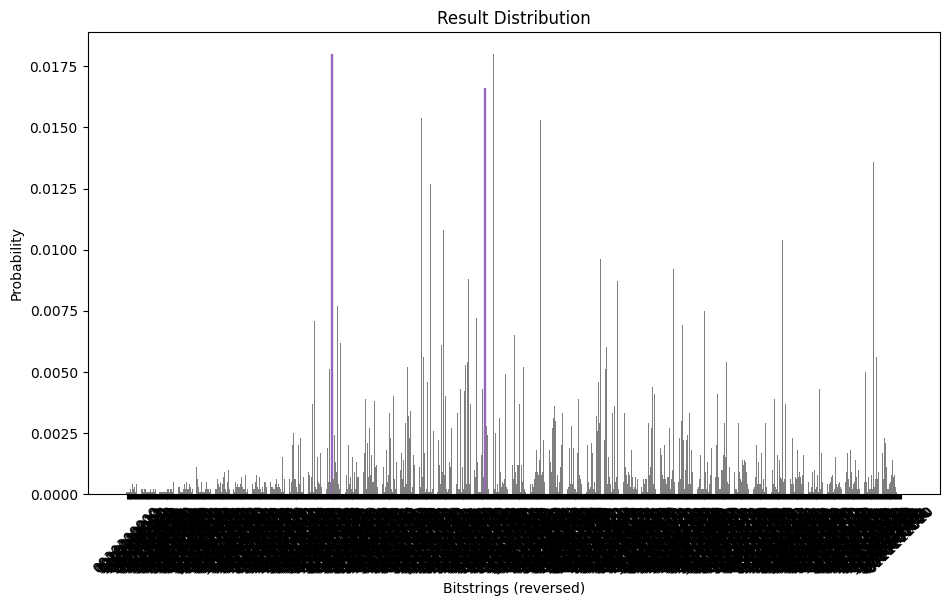

In [ ]:
import matplotlib
matplotlib.rcParams.update({"font.size": 10})

bitstring_labels = [''.join(map(str, to_bitstring(k, n)[::-1])) for k in keys]
top_4_values = sorted(values, reverse=True)[:4]
positions = [np.where(np.isclose(values, v))[0][0] for v in top_4_values]

fig, ax = plt.subplots(figsize=(11, 6))
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(bitstring_labels, values, color="tab:grey")
for p_ in positions:
    bars[p_].set_color("tab:purple")

plt.show()

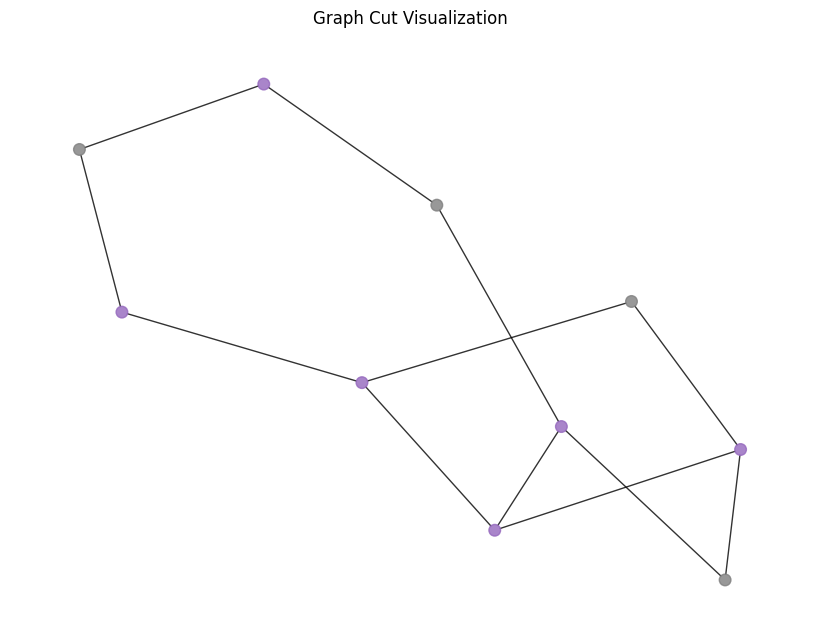

In [ ]:
def plot_result(G: rx.PyGraph, x: Sequence[int]):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title("Graph Cut Visualization")
    plt.show()

plot_result(graph, most_likely_bitstring)

In [ ]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "Length mismatch"
    cut_value = 0
    for u, v in graph.edge_list():
        cut_value += x[u] * (1 - x[v]) + x[v] * (1 - x[u])
    return cut_value

cut_val = evaluate_sample(most_likely_bitstring, graph)
print(f"The value of the cut is: {cut_val}")

The value of the cut is: 8


## depth = 3

In [ ]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from typing import Sequence

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler

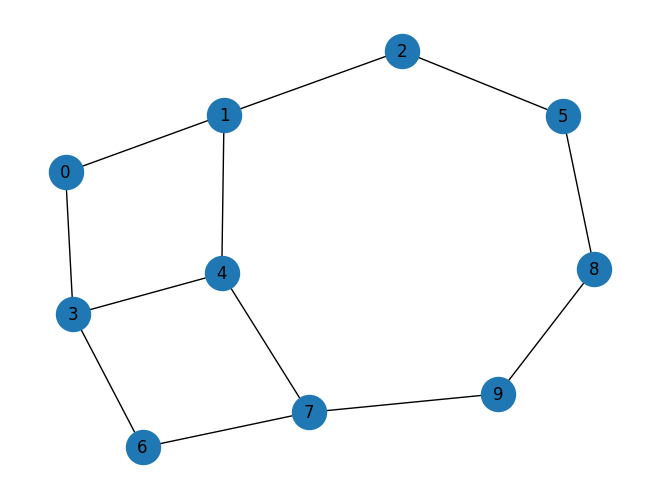

In [ ]:
import numpy as np
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

n = 10
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(n))

edge_list = [
    (0, 1, 1.0),
    (0, 3, 1.0),
    (1, 2, 1.0),
    (1, 4, 1.0),
    (2, 5, 1.0),
    (3, 4, 1.0),
    (3, 6, 1.0),
    (4, 7, 1.0),
    (5, 8, 1.0),
    (6, 7, 1.0),
    (7, 9, 1.0),
    (8, 9, 1.0),
]

graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [ ]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, list[int], float]]:
    pauli_list = []
    for u, v in graph.edge_list():
        weight = graph.get_edge_data(u, v)
        pauli_list.append(("ZZ", [u, v], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, num_qubits=n)
print("Cost Function Hamiltonian:\n", cost_hamiltonian)

Cost Function Hamiltonian:
 SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIZIIZ', 'IIIIIIIZZI', 'IIIIIZIIZI', 'IIIIZIIZII', 'IIIIIZZIII', 'IIIZIIZIII', 'IIZIIZIIII', 'IZIIZIIIII', 'IIZZIIIIII', 'ZIZIIIIIII', 'ZZIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j])


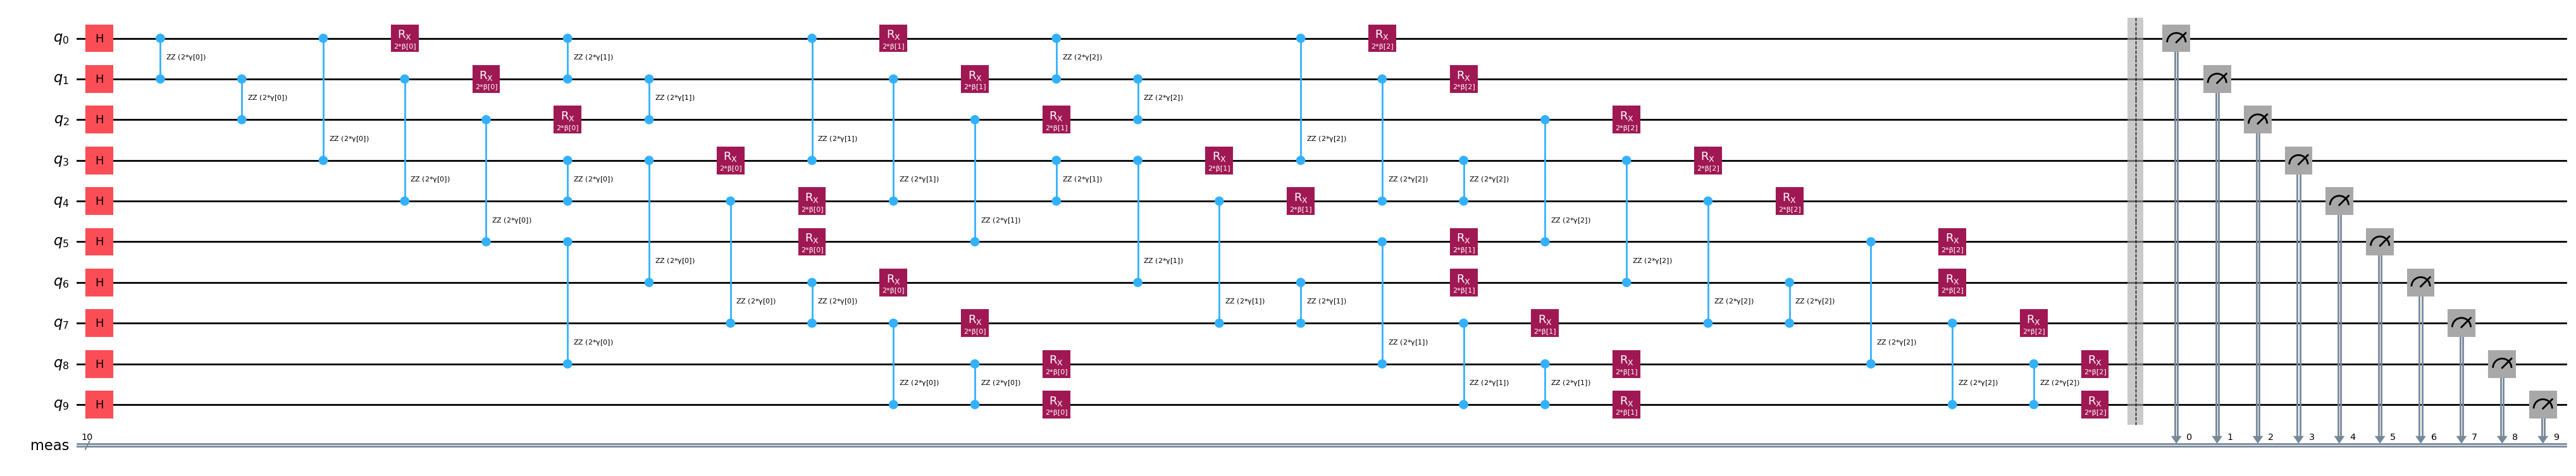

In [ ]:
p = 3
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()
candidate_circuit = transpile(circuit, backend=AerSimulator(), optimization_level=3)
candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta] * p + [initial_gamma] * p

objective_func_vals = []

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    job = estimator.run(
        circuits=[ansatz],
        observables=[hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost

estimator = Estimator()

result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -6.984375
       x: [ 1.990e+00  2.472e+00  1.427e+00  3.577e+00  2.971e+00
            3.099e+00]
    nfev: 47
   maxcv: 0.0


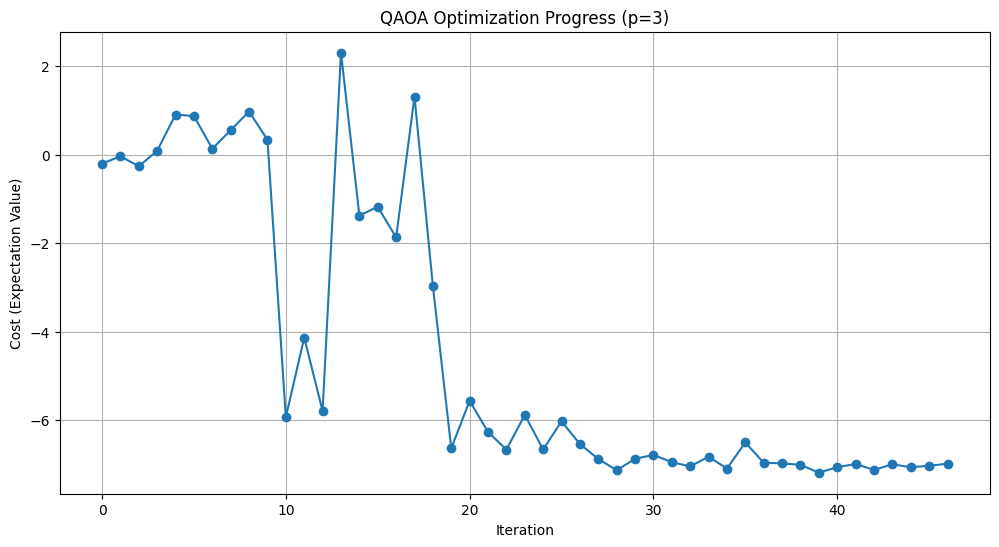

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Cost (Expectation Value)")
plt.title(f"QAOA Optimization Progress (p={p})")
plt.grid(True)
plt.show()

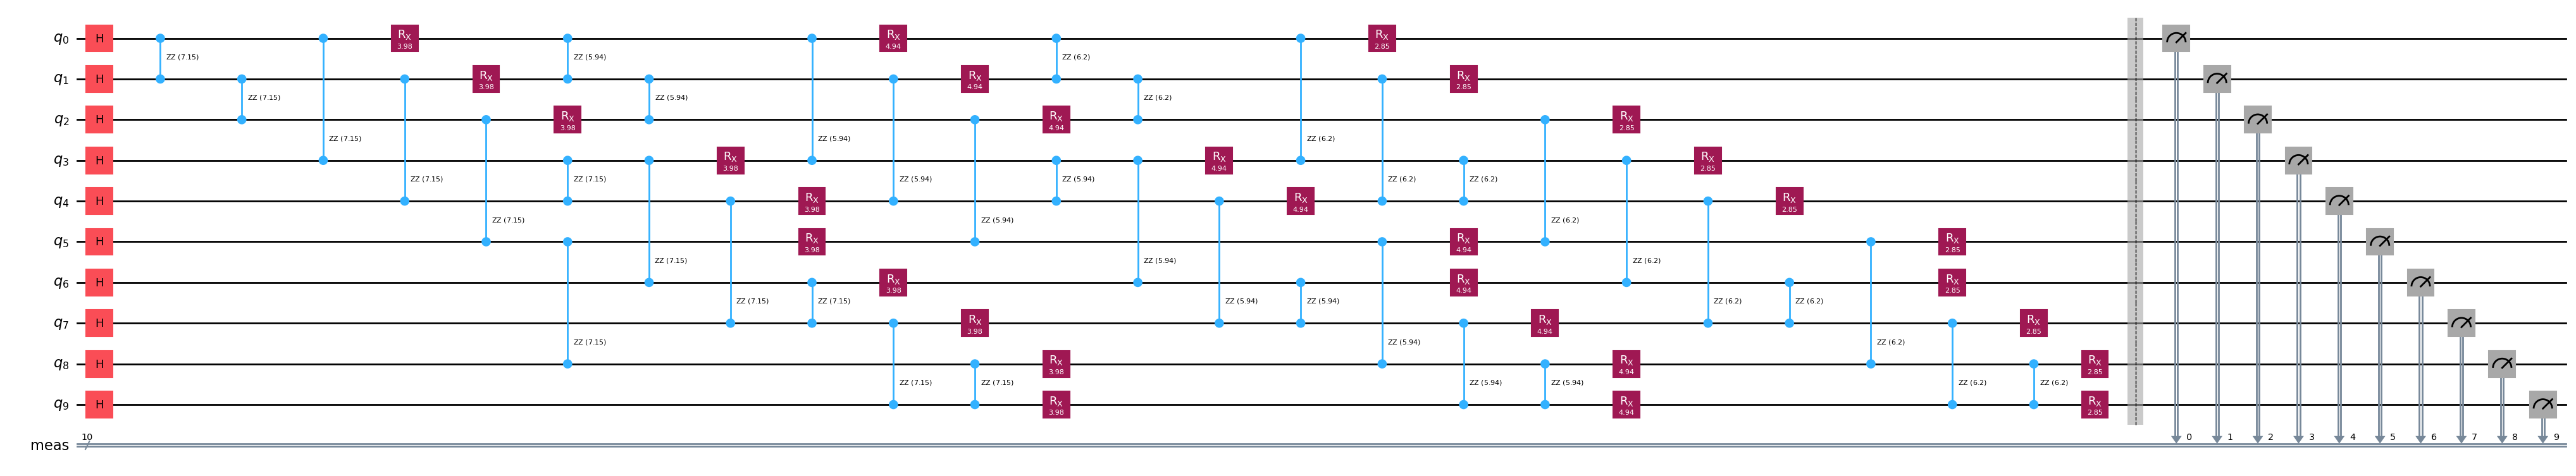

In [ ]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
sampler = Sampler()
job = sampler.run([optimized_circuit], shots=10_000)
res = job.result()

quasi_dist = res.quasi_dists[0]
final_distribution_int = {}
for k, v in quasi_dist.items():
    if isinstance(k, str):
        final_distribution_int[int(k, 2)] = float(v)
    else:
        final_distribution_int[k] = float(v)

print(final_distribution_int)

{553: 0.0003, 223: 0.0001, 740: 0.0001, 274: 0.0001, 357: 0.0001, 442: 0.0001, 5: 0.0001, 474: 0.0003, 390: 0.0001, 161: 0.0004, 742: 0.0001, 34: 0.0001, 605: 0.0001, 213: 0.0001, 833: 0.0001, 377: 0.0001, 649: 0.0001, 447: 0.0002, 707: 0.0001, 690: 0.0001, 718: 0.0001, 291: 0.0003, 738: 0.0005, 332: 0.0002, 388: 0.0003, 414: 0.0001, 630: 0.0001, 101: 0.0001, 847: 0.0002, 283: 0.0001, 313: 0.0001, 261: 0.0001, 519: 0.0001, 148: 0.0001, 380: 0.0001, 410: 0.0001, 236: 0.0001, 911: 0.0001, 785: 0.0001, 940: 0.0001, 978: 0.0003, 836: 0.0001, 855: 0.0001, 714: 0.0001, 484: 0.0001, 37: 0.0001, 817: 0.0002, 818: 0.0001, 97: 0.0001, 926: 0.0001, 204: 0.0002, 415: 0.0002, 744: 0.0001, 298: 0.0002, 591: 0.0004, 242: 0.0004, 445: 0.0002, 266: 0.0001, 444: 0.0002, 94: 0.0001, 972: 0.0001, 516: 0.0001, 487: 0.0002, 245: 0.001, 964: 0.0001, 559: 0.0001, 917: 0.0003, 837: 0.0001, 711: 0.0002, 905: 0.0001, 614: 0.0003, 762: 0.0002, 185: 0.0007, 524: 0.0006, 547: 0.0004, 347: 0.0001, 188: 0.001, 592: 0

In [ ]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(values)]

most_likely_bitstring = to_bitstring(most_likely, n)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


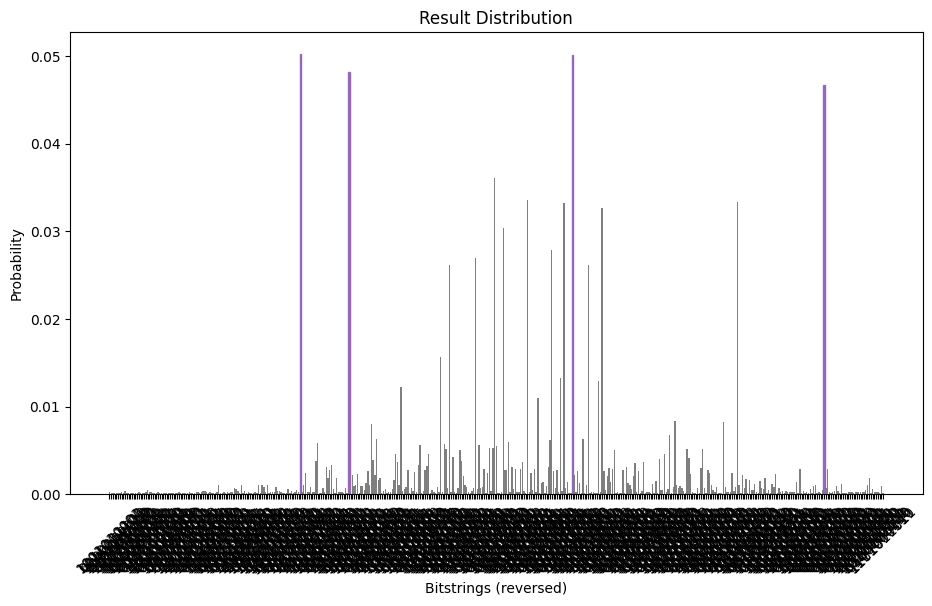

In [ ]:
import matplotlib
matplotlib.rcParams.update({"font.size": 10})

bitstring_labels = [''.join(map(str, to_bitstring(k, n)[::-1])) for k in keys]
top_4_values = sorted(values, reverse=True)[:4]
positions = [np.where(np.isclose(values, v))[0][0] for v in top_4_values]

fig, ax = plt.subplots(figsize=(11, 6))
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(bitstring_labels, values, color="tab:grey")
for p_ in positions:
    bars[p_].set_color("tab:purple")

plt.show()

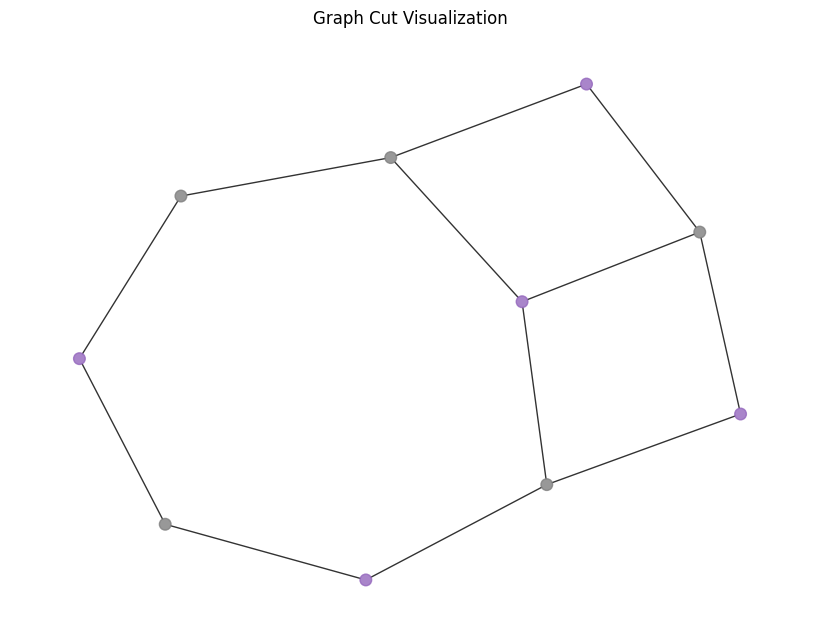

In [ ]:
def plot_result(G: rx.PyGraph, x: Sequence[int]):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title("Graph Cut Visualization")
    plt.show()

plot_result(graph, most_likely_bitstring)

In [ ]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "Length mismatch"
    cut_value = 0
    for u, v in graph.edge_list():
        cut_value += x[u] * (1 - x[v]) + x[v] * (1 - x[u])
    return cut_value

cut_val = evaluate_sample(most_likely_bitstring, graph)
print(f"The value of the cut is: {cut_val}")

The value of the cut is: 11


# Node 20

## depth = 1

In [ ]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from typing import Sequence

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler

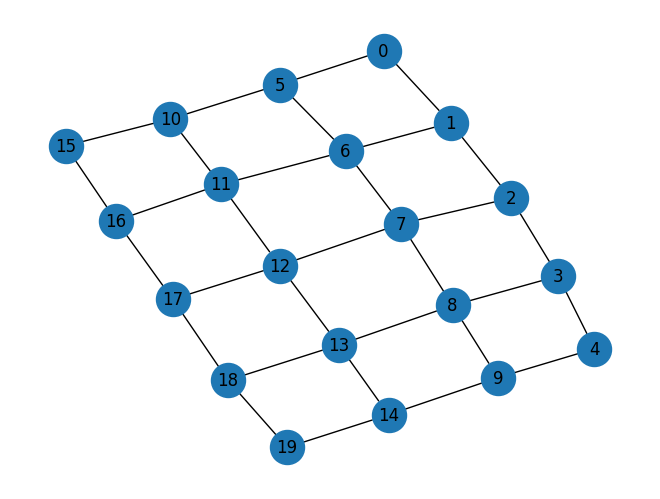

In [ ]:
n = 20
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(n))

edge_list = [
    (0, 1, 1.0),
    (0, 5, 1.0),
    (1, 2, 1.0),
    (1, 6, 1.0),
    (2, 3, 1.0),
    (2, 7, 1.0),
    (3, 4, 1.0),
    (3, 8, 1.0),
    (4, 9, 1.0),
    (5, 6, 1.0),
    (5, 10, 1.0),
    (6, 7, 1.0),
    (6, 11, 1.0),
    (7, 8, 1.0),
    (7, 12, 1.0),
    (8, 9, 1.0),
    (8, 13, 1.0),
    (9, 14, 1.0),
    (10, 11, 1.0),
    (11, 12, 1.0),
    (12, 13, 1.0),
    (13, 14, 1.0),
    (10, 15, 1.0),
    (11, 16, 1.0),
    (12, 17, 1.0),
    (13, 18, 1.0),
    (14, 19, 1.0),
    (15, 16, 1.0),
    (16, 17, 1.0),
    (17, 18, 1.0),
    (18, 19, 1.0),
]

graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [ ]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, list[int], float]]:
    pauli_list = []
    for u, v in graph.edge_list():
        weight = graph.get_edge_data(u, v)
        pauli_list.append(("ZZ", [u, v], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, num_qubits=n)
print("Cost Function Hamiltonian:\n", cost_hamiltonian)

Cost Function Hamiltonian:
 SparsePauliOp(['IIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIZIIIIZ', 'IIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIZIIIIZI', 'IIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIZIIIIZII', 'IIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIZIIIIZIII', 'IIIIIIIIIIZIIIIZIIII', 'IIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIZIIIIZIIIII', 'IIIIIIIIIIIIZZIIIIII', 'IIIIIIIIZIIIIZIIIIII', 'IIIIIIIIIIIZZIIIIIII', 'IIIIIIIZIIIIZIIIIIII', 'IIIIIIIIIIZZIIIIIIII', 'IIIIIIZIIIIZIIIIIIII', 'IIIIIZIIIIZIIIIIIIII', 'IIIIIIIIZZIIIIIIIIII', 'IIIIIIIZZIIIIIIIIIII', 'IIIIIIZZIIIIIIIIIIII', 'IIIIIZZIIIIIIIIIIIII', 'IIIIZIIIIZIIIIIIIIII', 'IIIZIIIIZIIIIIIIIIII', 'IIZIIIIZIIIIIIIIIIII', 'IZIIIIZIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIII', 'IIIZZIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIII', 'IZZIIIIIIIIIIIIIIIII', 'ZZIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0

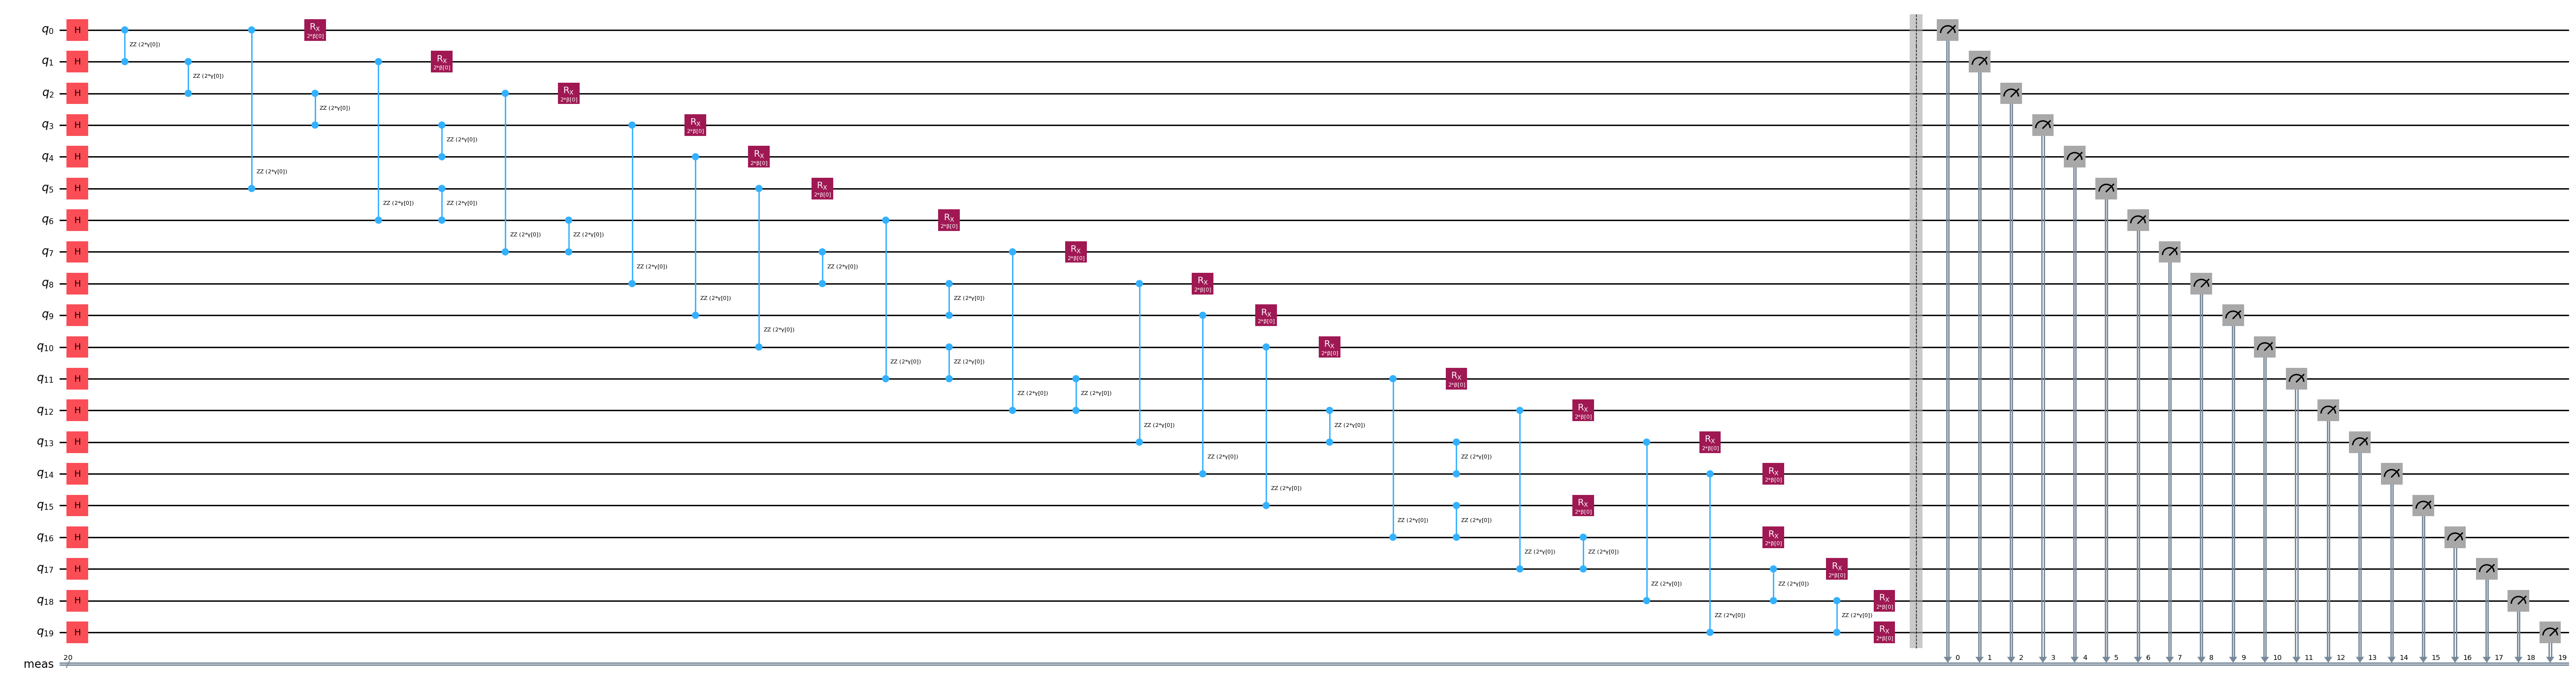

In [ ]:
p = 1
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()
candidate_circuit = transpile(circuit, backend=AerSimulator(), optimization_level=3)
candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta] * p + [initial_gamma] * p

objective_func_vals = []

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    job = estimator.run(
        circuits=[ansatz],
        observables=[hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost

estimator = Estimator()

result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -11.15625
       x: [ 4.071e-01  2.897e+00]
    nfev: 22
   maxcv: 0.0


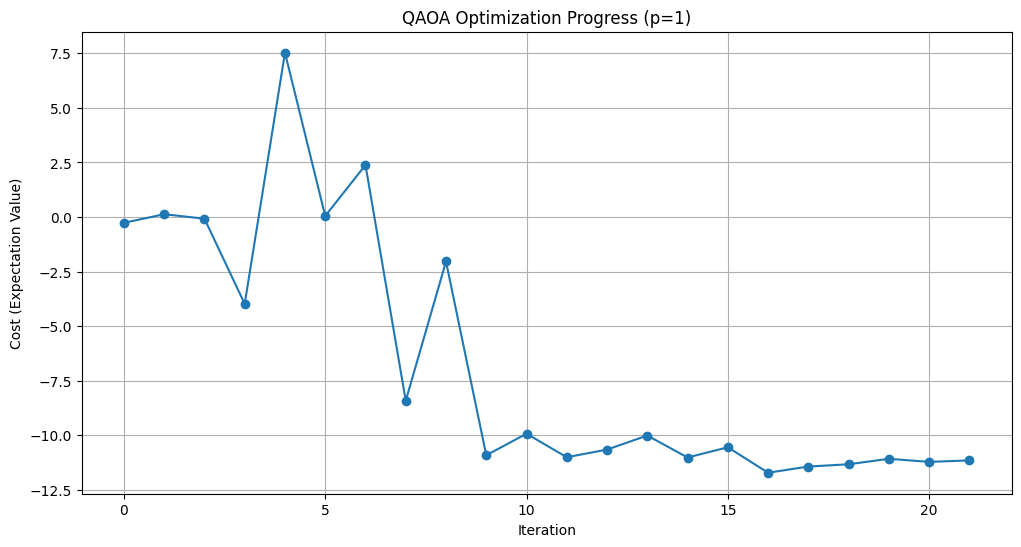

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Cost (Expectation Value)")
plt.title(f"QAOA Optimization Progress (p={p})")
plt.grid(True)
plt.show()

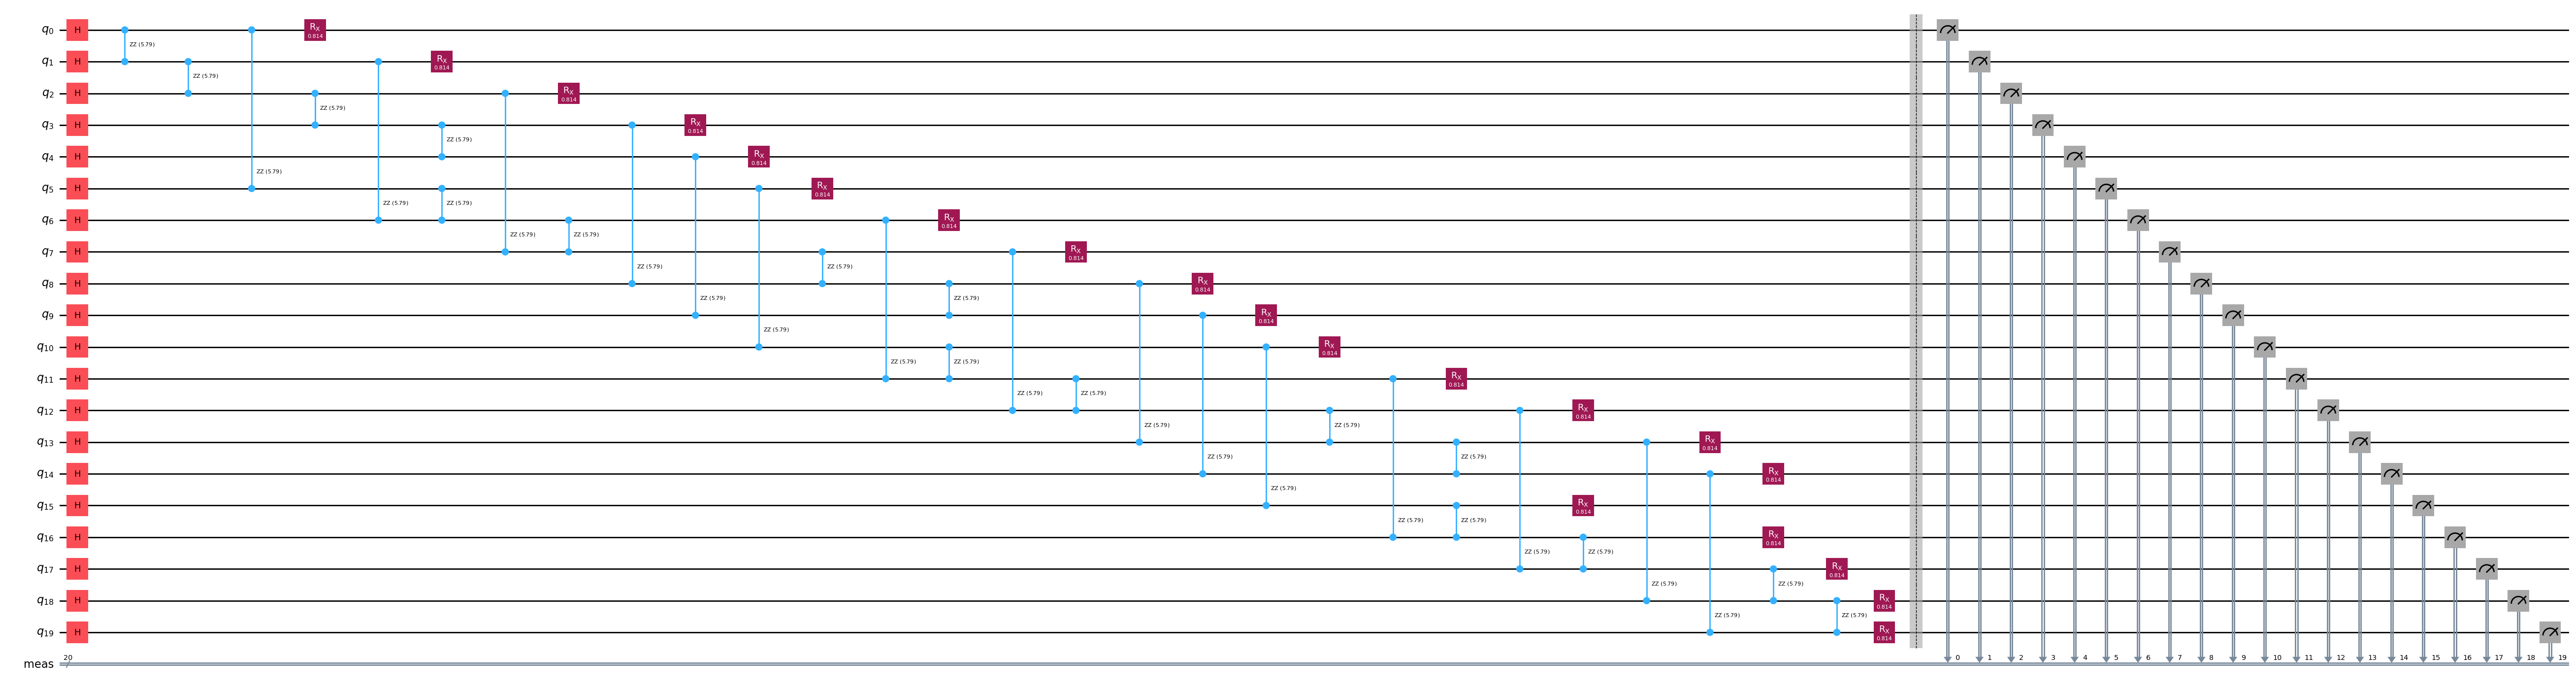

In [ ]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
sampler = Sampler()
job = sampler.run([optimized_circuit], shots=10_000)
res = job.result()

quasi_dist = res.quasi_dists[0]
final_distribution_int = {}
for k, v in quasi_dist.items():
    if isinstance(k, str):
        final_distribution_int[int(k, 2)] = float(v)
    else:
        final_distribution_int[k] = float(v)

print(final_distribution_int)

{572245: 0.0001, 333013: 0.0001, 353745: 0.0001, 911563: 0.0001, 700586: 0.0001, 317282: 0.0002, 595814: 0.0001, 621935: 0.0001, 907946: 0.0001, 349208: 0.0001, 286066: 0.0001, 697673: 0.0002, 957145: 0.0001, 730548: 0.0001, 603699: 0.0001, 240469: 0.0001, 730821: 0.0001, 191270: 0.0001, 143114: 0.0001, 381006: 0.0001, 698996: 0.0002, 349685: 0.0001, 897357: 0.0001, 602934: 0.0001, 767639: 0.0001, 698544: 0.0001, 873774: 0.0001, 953685: 0.0001, 47685: 0.0001, 341911: 0.0001, 350393: 0.0001, 602467: 0.0001, 240442: 0.0001, 158923: 0.0001, 605558: 0.0001, 159366: 0.0001, 741746: 0.0001, 341584: 0.0001, 420010: 0.0001, 333521: 0.0001, 955254: 0.0001, 571563: 0.0001, 513363: 0.0001, 349259: 0.0001, 318313: 0.0002, 412890: 0.0001, 382324: 0.0001, 954218: 0.0001, 874810: 0.0001, 894790: 0.0001, 510394: 0.0001, 345770: 0.0001, 572089: 0.0002, 838098: 0.0001, 321652: 0.0001, 193194: 0.0001, 341836: 0.0001, 865962: 0.0001, 666548: 0.0001, 872108: 0.0001, 195923: 0.0001, 603989: 0.0001, 993979: 

In [ ]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(values)]

most_likely_bitstring = to_bitstring(most_likely, n)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]


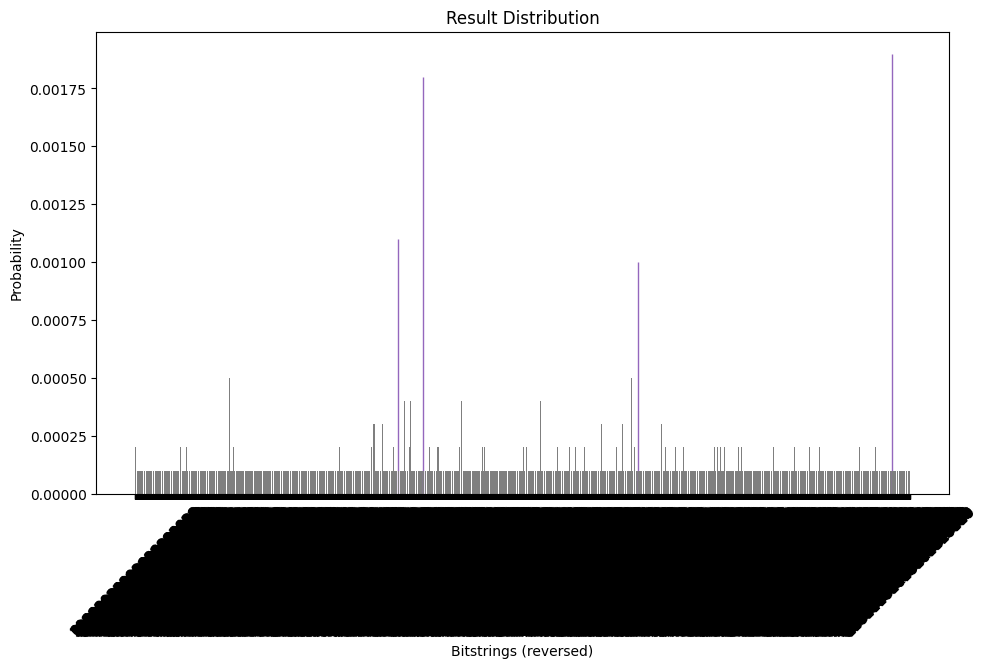

In [ ]:
import matplotlib
matplotlib.rcParams.update({"font.size": 10})

bitstring_labels = [''.join(map(str, to_bitstring(k, n)[::-1])) for k in keys]
top_4_values = sorted(values, reverse=True)[:4]
positions = [np.where(np.isclose(values, v))[0][0] for v in top_4_values]

fig, ax = plt.subplots(figsize=(11, 6))
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(bitstring_labels, values, color="tab:grey")
for p_ in positions:
    bars[p_].set_color("tab:purple")

plt.show()

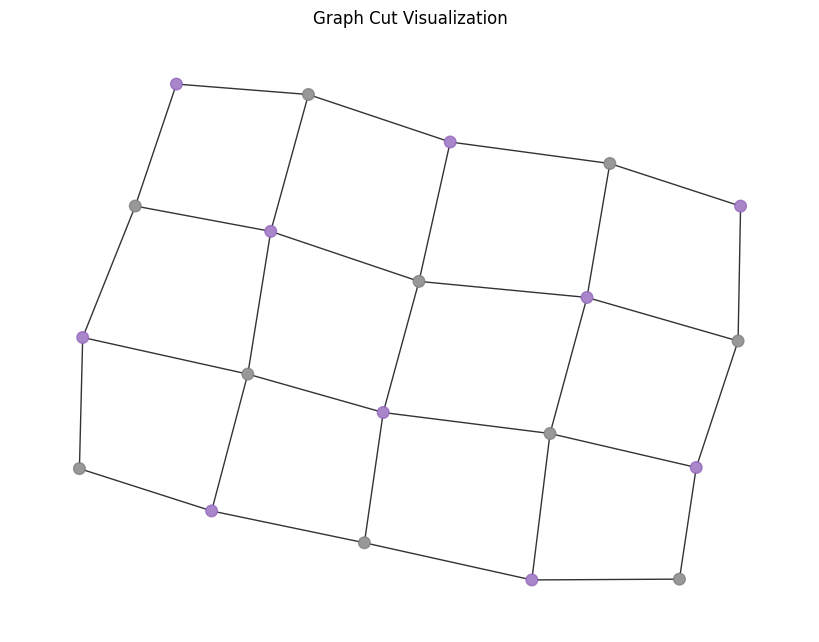

In [ ]:
def plot_result(G: rx.PyGraph, x: Sequence[int]):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title("Graph Cut Visualization")
    plt.show()

plot_result(graph, most_likely_bitstring)

In [ ]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "Length mismatch"
    cut_value = 0
    for u, v in graph.edge_list():
        cut_value += x[u] * (1 - x[v]) + x[v] * (1 - x[u])
    return cut_value

cut_val = evaluate_sample(most_likely_bitstring, graph)
print(f"The value of the cut is: {cut_val}")

The value of the cut is: 31


## depth = 2

In [ ]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from typing import Sequence

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler

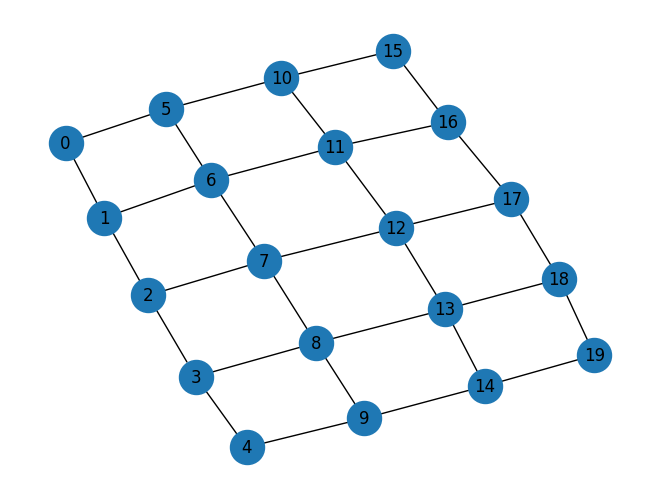

In [ ]:
n = 20
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(n))

edge_list = [
    (0, 1, 1.0),
    (0, 5, 1.0),
    (1, 2, 1.0),
    (1, 6, 1.0),
    (2, 3, 1.0),
    (2, 7, 1.0),
    (3, 4, 1.0),
    (3, 8, 1.0),
    (4, 9, 1.0),
    (5, 6, 1.0),
    (5, 10, 1.0),
    (6, 7, 1.0),
    (6, 11, 1.0),
    (7, 8, 1.0),
    (7, 12, 1.0),
    (8, 9, 1.0),
    (8, 13, 1.0),
    (9, 14, 1.0),
    (10, 11, 1.0),
    (11, 12, 1.0),
    (12, 13, 1.0),
    (13, 14, 1.0),
    (10, 15, 1.0),
    (11, 16, 1.0),
    (12, 17, 1.0),
    (13, 18, 1.0),
    (14, 19, 1.0),
    (15, 16, 1.0),
    (16, 17, 1.0),
    (17, 18, 1.0),
    (18, 19, 1.0),
]

graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [ ]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, list[int], float]]:
    pauli_list = []
    for u, v in graph.edge_list():
        weight = graph.get_edge_data(u, v)
        pauli_list.append(("ZZ", [u, v], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, num_qubits=n)
print("Cost Function Hamiltonian:\n", cost_hamiltonian)

Cost Function Hamiltonian:
 SparsePauliOp(['IIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIZIIIIZ', 'IIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIZIIIIZI', 'IIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIZIIIIZII', 'IIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIZIIIIZIII', 'IIIIIIIIIIZIIIIZIIII', 'IIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIZIIIIZIIIII', 'IIIIIIIIIIIIZZIIIIII', 'IIIIIIIIZIIIIZIIIIII', 'IIIIIIIIIIIZZIIIIIII', 'IIIIIIIZIIIIZIIIIIII', 'IIIIIIIIIIZZIIIIIIII', 'IIIIIIZIIIIZIIIIIIII', 'IIIIIZIIIIZIIIIIIIII', 'IIIIIIIIZZIIIIIIIIII', 'IIIIIIIZZIIIIIIIIIII', 'IIIIIIZZIIIIIIIIIIII', 'IIIIIZZIIIIIIIIIIIII', 'IIIIZIIIIZIIIIIIIIII', 'IIIZIIIIZIIIIIIIIIII', 'IIZIIIIZIIIIIIIIIIII', 'IZIIIIZIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIII', 'IIIZZIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIII', 'IZZIIIIIIIIIIIIIIIII', 'ZZIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0

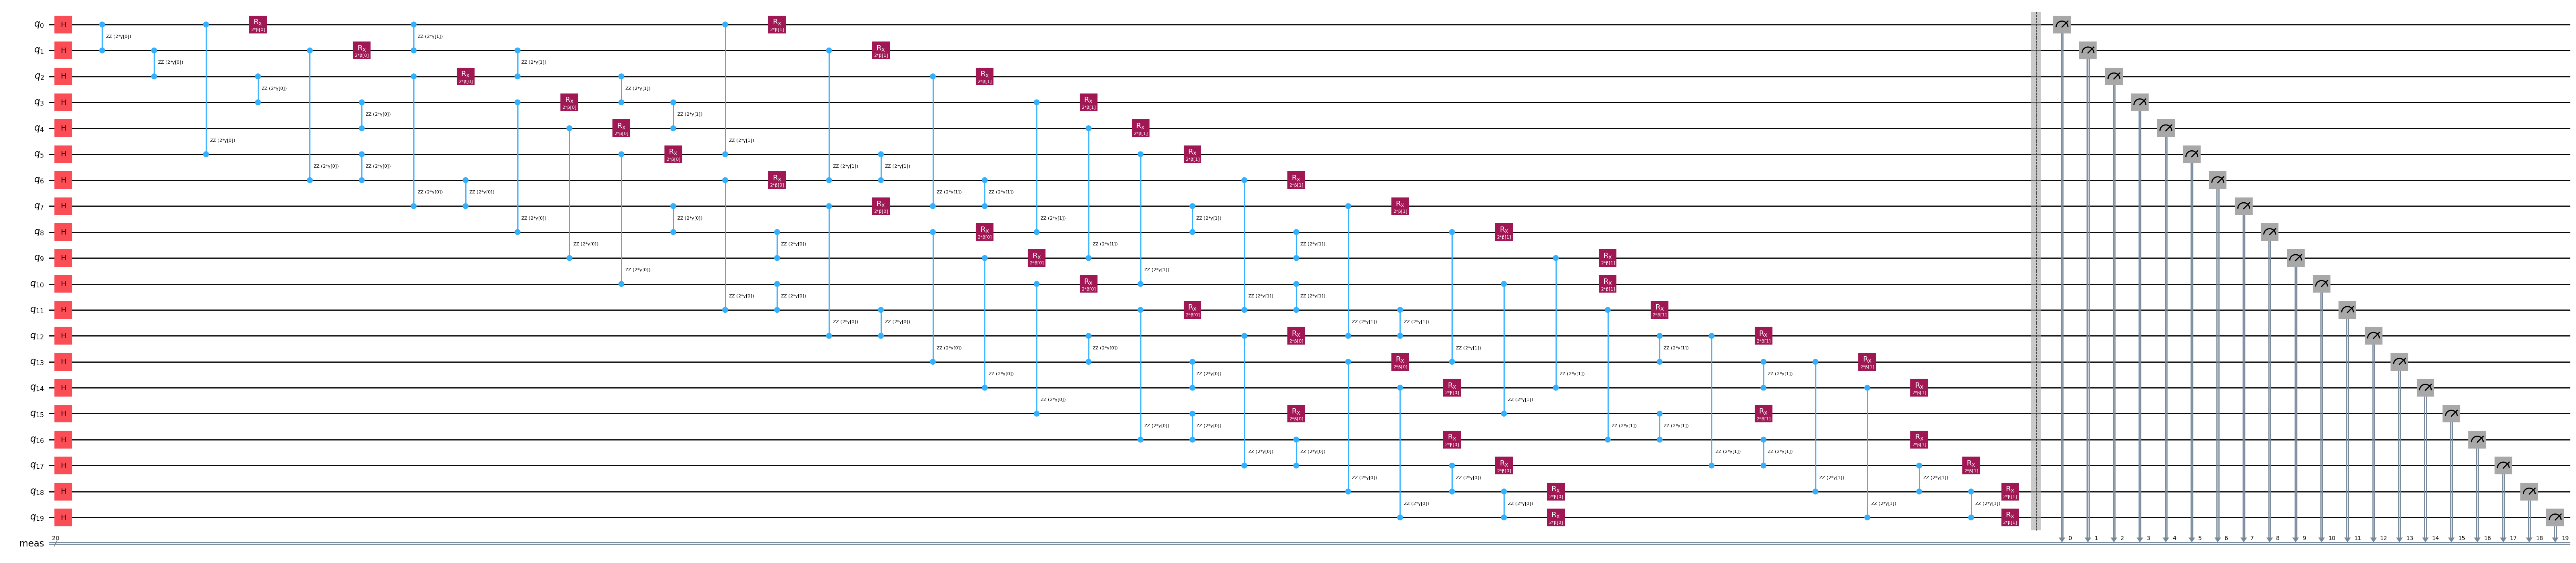

In [ ]:
p = 2
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()
candidate_circuit = transpile(circuit, backend=AerSimulator(), optimization_level=3)
candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta] * p + [initial_gamma] * p

objective_func_vals = []

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    job = estimator.run(
        circuits=[ansatz],
        observables=[hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost

estimator = Estimator()

result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -11.08203125
       x: [ 1.574e+00  1.891e+00  3.062e+00  2.926e+00]
    nfev: 31
   maxcv: 0.0


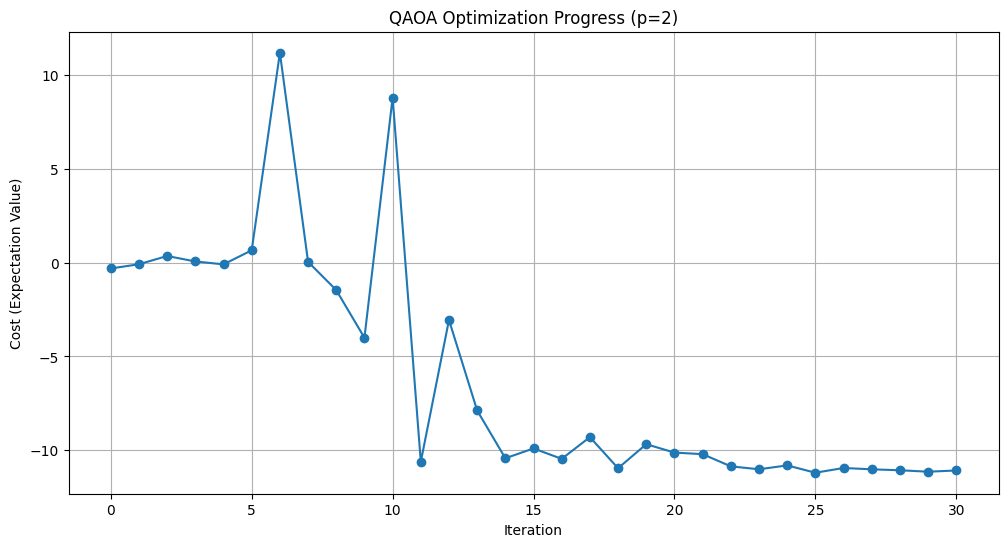

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Cost (Expectation Value)")
plt.title(f"QAOA Optimization Progress (p={p})")
plt.grid(True)
plt.show()

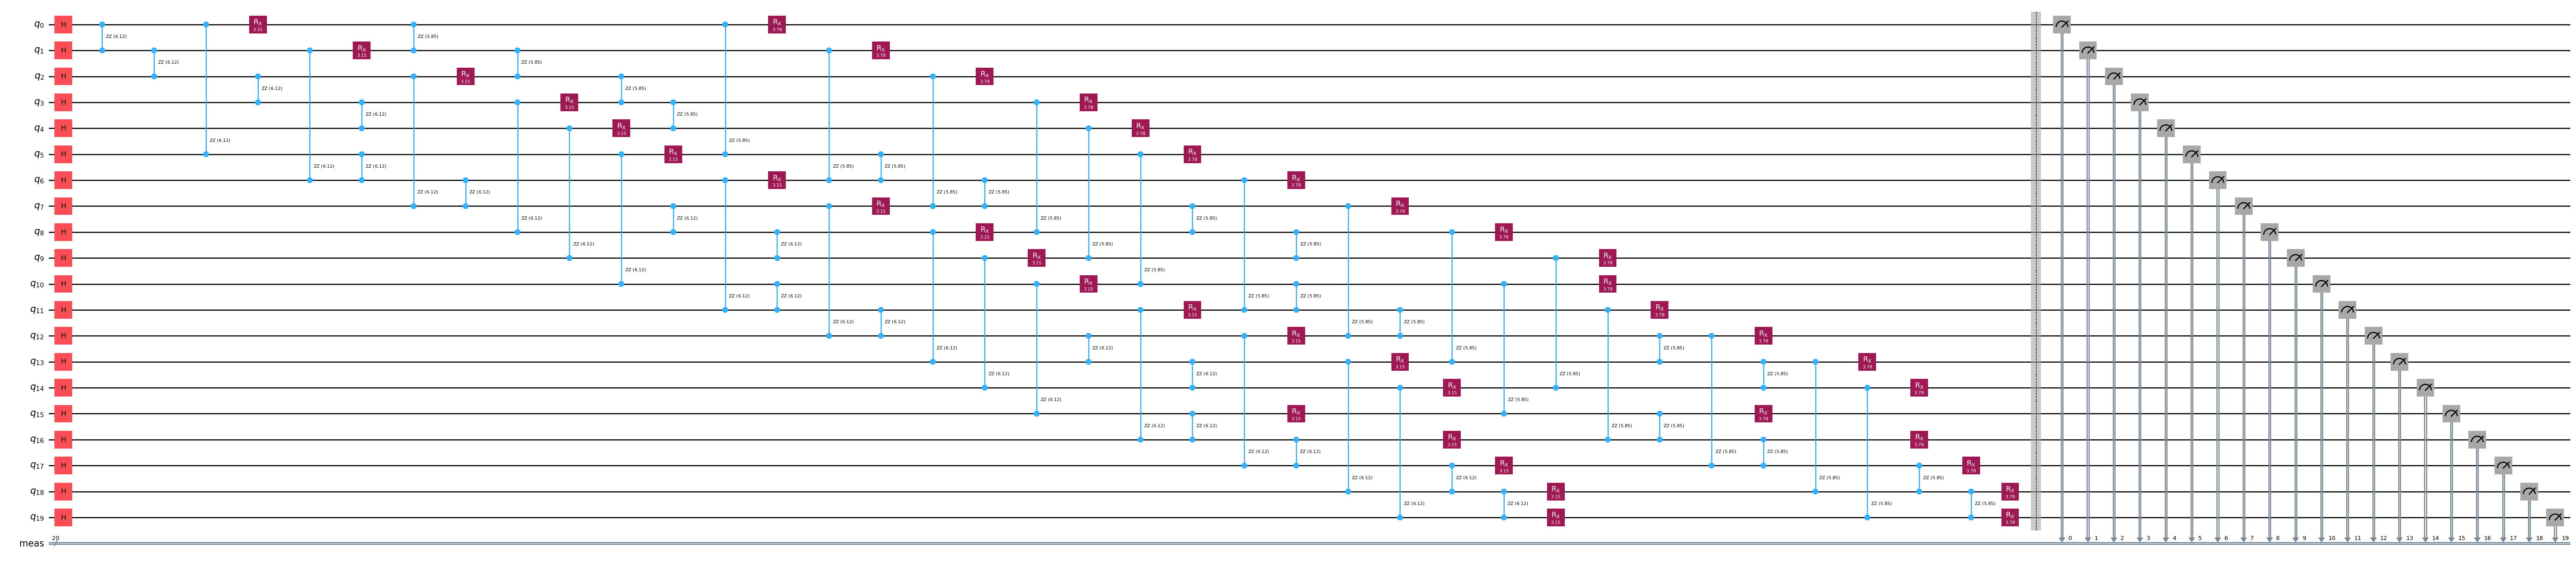

In [ ]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
sampler = Sampler()
job = sampler.run([optimized_circuit], shots=10_000)
res = job.result()

quasi_dist = res.quasi_dists[0]
final_distribution_int = {}
for k, v in quasi_dist.items():
    if isinstance(k, str):
        final_distribution_int[int(k, 2)] = float(v)
    else:
        final_distribution_int[k] = float(v)

print(final_distribution_int)

{619725: 0.0001, 378290: 0.0001, 587962: 0.0001, 510125: 0.0001, 269173: 0.0001, 631474: 0.0001, 47663: 0.0001, 373291: 0.0001, 444749: 0.0001, 690618: 0.0001, 794189: 0.0001, 658222: 0.0001, 570282: 0.0001, 740676: 0.0001, 698965: 0.0003, 681636: 0.0001, 606454: 0.0001, 638658: 0.0001, 370327: 0.0001, 689089: 0.0001, 190775: 0.0001, 697491: 0.0001, 763686: 0.0001, 970061: 0.0001, 613778: 0.0001, 354988: 0.0001, 221269: 0.0001, 704804: 0.0001, 191212: 0.0001, 332082: 0.0001, 348533: 0.0002, 706669: 0.0001, 63802: 0.0001, 714933: 0.0002, 595750: 0.0001, 357424: 0.0001, 430701: 0.0001, 857903: 0.0001, 373357: 0.0001, 730697: 0.0001, 46921: 0.0001, 285077: 0.0001, 154910: 0.0001, 428714: 0.0001, 791988: 0.0001, 174515: 0.0002, 221433: 0.0001, 428842: 0.0001, 309403: 0.0001, 857995: 0.0001, 416244: 0.0001, 476805: 0.0001, 600246: 0.0001, 870835: 0.0001, 597971: 0.0001, 699069: 0.0001, 349804: 0.0002, 604740: 0.0001, 382165: 0.0001, 718412: 0.0001, 869593: 0.0001, 317138: 0.0001, 202566: 0.

In [ ]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(values)]

most_likely_bitstring = to_bitstring(most_likely, n)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]


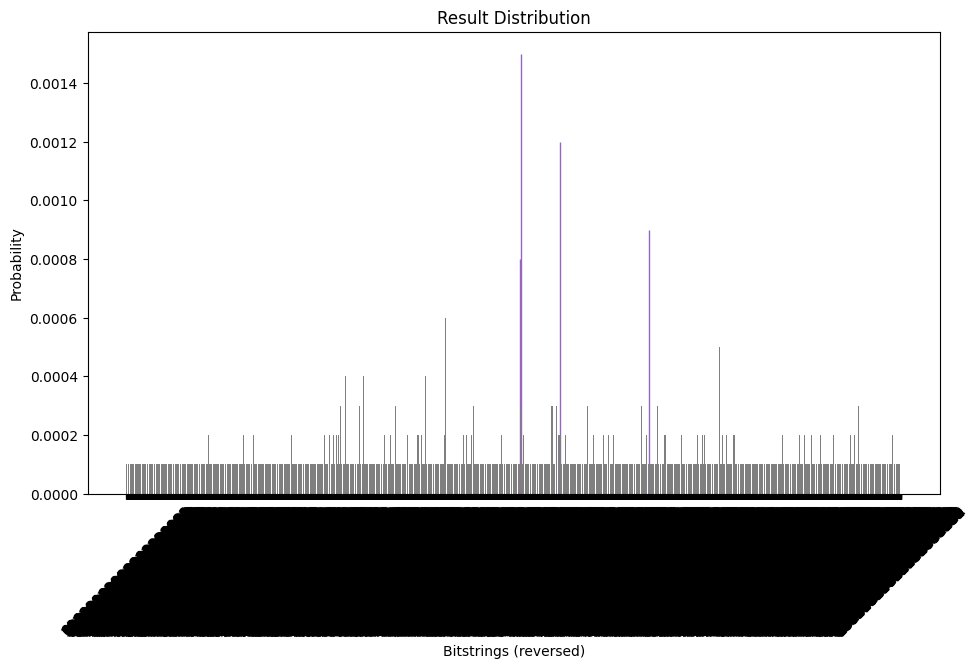

In [ ]:
import matplotlib
matplotlib.rcParams.update({"font.size": 10})

bitstring_labels = [''.join(map(str, to_bitstring(k, n)[::-1])) for k in keys]
top_4_values = sorted(values, reverse=True)[:4]
positions = [np.where(np.isclose(values, v))[0][0] for v in top_4_values]

fig, ax = plt.subplots(figsize=(11, 6))
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(bitstring_labels, values, color="tab:grey")
for p_ in positions:
    bars[p_].set_color("tab:purple")

plt.show()

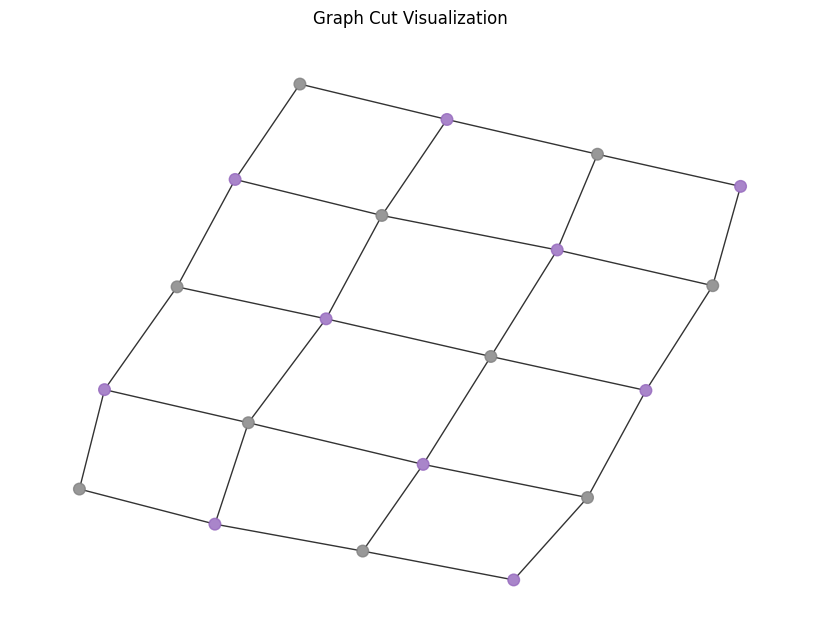

In [ ]:
def plot_result(G: rx.PyGraph, x: Sequence[int]):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title("Graph Cut Visualization")
    plt.show()

plot_result(graph, most_likely_bitstring)

In [ ]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "Length mismatch"
    cut_value = 0
    for u, v in graph.edge_list():
        cut_value += x[u] * (1 - x[v]) + x[v] * (1 - x[u])
    return cut_value

cut_val = evaluate_sample(most_likely_bitstring, graph)
print(f"The value of the cut is: {cut_val}")

The value of the cut is: 31


## depth = 3

In [ ]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from typing import Sequence

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler

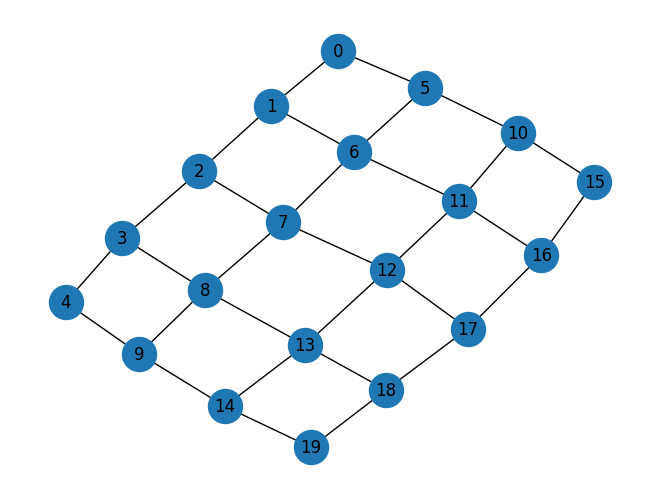

In [ ]:
n = 20
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(n))

edge_list = [
    (0, 1, 1.0),
    (0, 5, 1.0),
    (1, 2, 1.0),
    (1, 6, 1.0),
    (2, 3, 1.0),
    (2, 7, 1.0),
    (3, 4, 1.0),
    (3, 8, 1.0),
    (4, 9, 1.0),
    (5, 6, 1.0),
    (5, 10, 1.0),
    (6, 7, 1.0),
    (6, 11, 1.0),
    (7, 8, 1.0),
    (7, 12, 1.0),
    (8, 9, 1.0),
    (8, 13, 1.0),
    (9, 14, 1.0),
    (10, 11, 1.0),
    (11, 12, 1.0),
    (12, 13, 1.0),
    (13, 14, 1.0),
    (10, 15, 1.0),
    (11, 16, 1.0),
    (12, 17, 1.0),
    (13, 18, 1.0),
    (14, 19, 1.0),
    (15, 16, 1.0),
    (16, 17, 1.0),
    (17, 18, 1.0),
    (18, 19, 1.0),
]

graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [ ]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, list[int], float]]:
    pauli_list = []
    for u, v in graph.edge_list():
        weight = graph.get_edge_data(u, v)
        pauli_list.append(("ZZ", [u, v], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, num_qubits=n)
print("Cost Function Hamiltonian:\n", cost_hamiltonian)

Cost Function Hamiltonian:
 SparsePauliOp(['IIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIZIIIIZ', 'IIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIZIIIIZI', 'IIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIZIIIIZII', 'IIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIZIIIIZIII', 'IIIIIIIIIIZIIIIZIIII', 'IIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIZIIIIZIIIII', 'IIIIIIIIIIIIZZIIIIII', 'IIIIIIIIZIIIIZIIIIII', 'IIIIIIIIIIIZZIIIIIII', 'IIIIIIIZIIIIZIIIIIII', 'IIIIIIIIIIZZIIIIIIII', 'IIIIIIZIIIIZIIIIIIII', 'IIIIIZIIIIZIIIIIIIII', 'IIIIIIIIZZIIIIIIIIII', 'IIIIIIIZZIIIIIIIIIII', 'IIIIIIZZIIIIIIIIIIII', 'IIIIIZZIIIIIIIIIIIII', 'IIIIZIIIIZIIIIIIIIII', 'IIIZIIIIZIIIIIIIIIII', 'IIZIIIIZIIIIIIIIIIII', 'IZIIIIZIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIII', 'IIIZZIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIII', 'IZZIIIIIIIIIIIIIIIII', 'ZZIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0

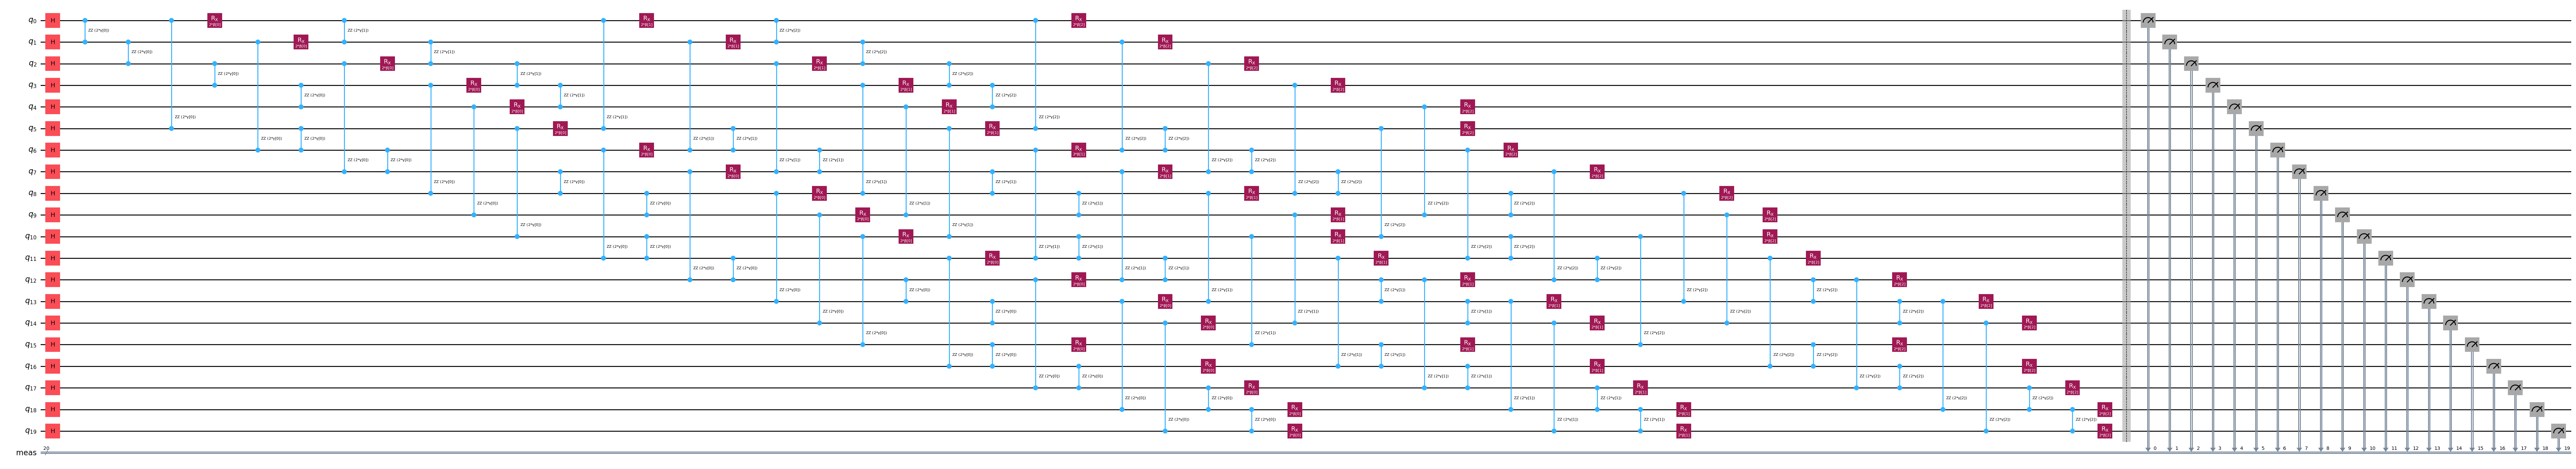

In [ ]:
p = 3
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()
candidate_circuit = transpile(circuit, backend=AerSimulator(), optimization_level=3)
candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta] * p + [initial_gamma] * p

objective_func_vals = []

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    job = estimator.run(
        circuits=[ansatz],
        observables=[hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost

estimator = Estimator()

result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -17.841796875
       x: [ 1.934e+00  1.897e+00  1.858e+00  3.000e+00  2.994e+00
            2.829e+00]
    nfev: 43
   maxcv: 0.0


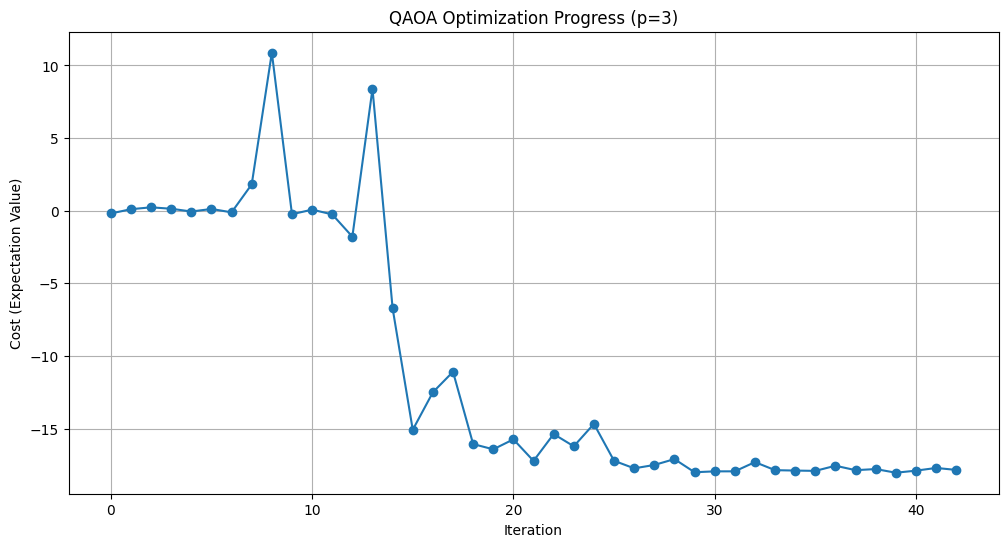

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Cost (Expectation Value)")
plt.title(f"QAOA Optimization Progress (p={p})")
plt.grid(True)
plt.show()

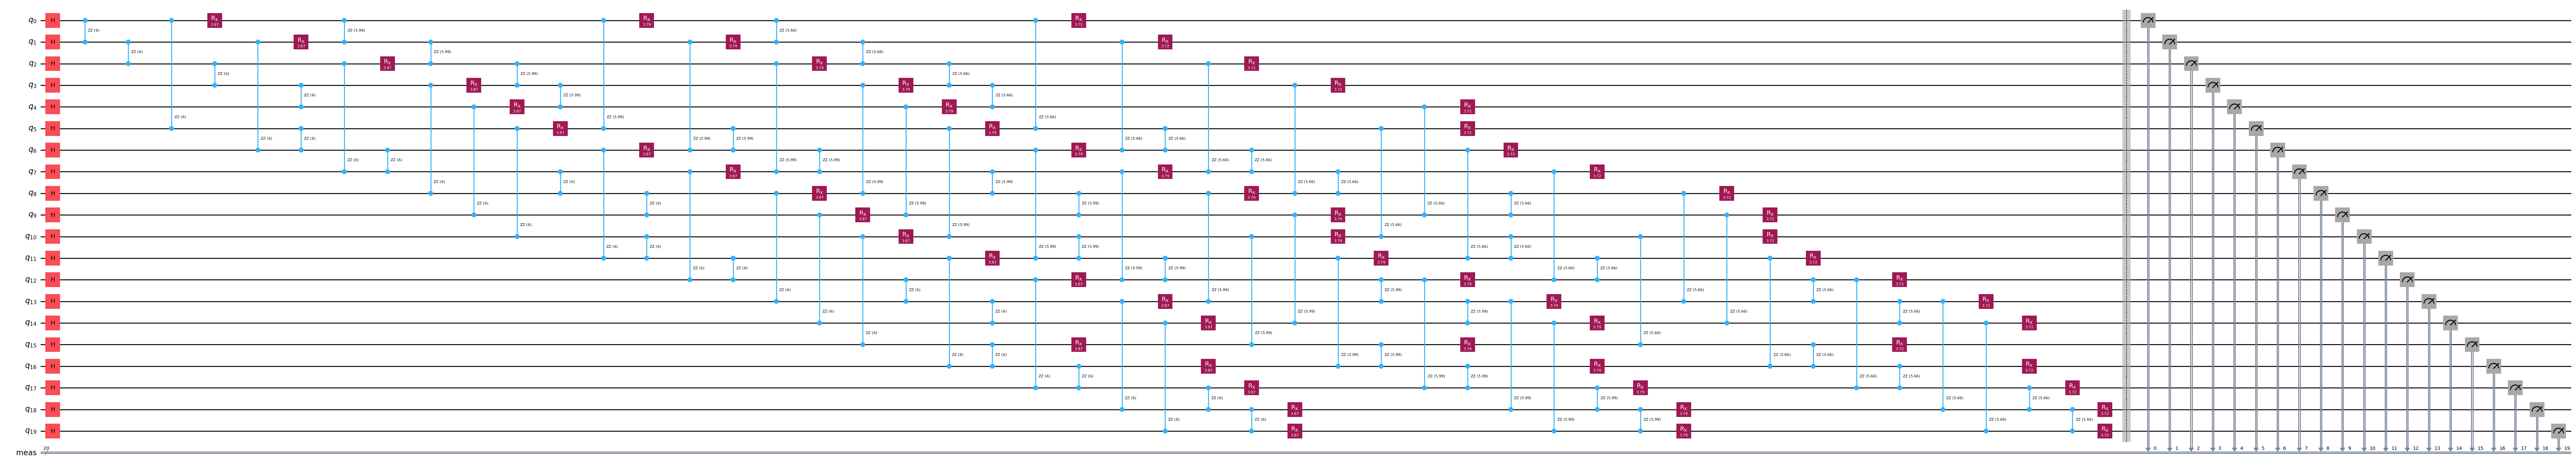

In [ ]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
sampler = Sampler()
job = sampler.run([optimized_circuit], shots=10_000)
res = job.result()

quasi_dist = res.quasi_dists[0]
final_distribution_int = {}
for k, v in quasi_dist.items():
    if isinstance(k, str):
        final_distribution_int[int(k, 2)] = float(v)
    else:
        final_distribution_int[k] = float(v)

print(final_distribution_int)

{483436: 0.0001, 222361: 0.0001, 175379: 0.0001, 373284: 0.0002, 977594: 0.0001, 316851: 0.0001, 595445: 0.0001, 731302: 0.0001, 354474: 0.0001, 478427: 0.0001, 698742: 0.0001, 217427: 0.0001, 715961: 0.0001, 381098: 0.0002, 305830: 0.0001, 191177: 0.0001, 382285: 0.0002, 667271: 0.0001, 665243: 0.0001, 764594: 0.0001, 731446: 0.0002, 644938: 0.0001, 857419: 0.0001, 747333: 0.0001, 158122: 0.0001, 350549: 0.0001, 869597: 0.0001, 957236: 0.0001, 341286: 0.0001, 956757: 0.0001, 861403: 0.0001, 667307: 0.0003, 834084: 0.0001, 381221: 0.0001, 293290: 0.0001, 890442: 0.0001, 353419: 0.0001, 970193: 0.0001, 159154: 0.0001, 452184: 0.0001, 255317: 0.0001, 349403: 0.0002, 365412: 0.0001, 695164: 0.0001, 382250: 0.0001, 309930: 0.0001, 713045: 0.0001, 732858: 0.0001, 740658: 0.0001, 339602: 0.0001, 432652: 0.0001, 546164: 0.0001, 993962: 0.0001, 730196: 0.0001, 617906: 0.0001, 152878: 0.0001, 698564: 0.0001, 603852: 0.0001, 447763: 0.0001, 892458: 0.0001, 95541: 0.0001, 864303: 0.0001, 669494: 

In [ ]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(values)]

most_likely_bitstring = to_bitstring(most_likely, n)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


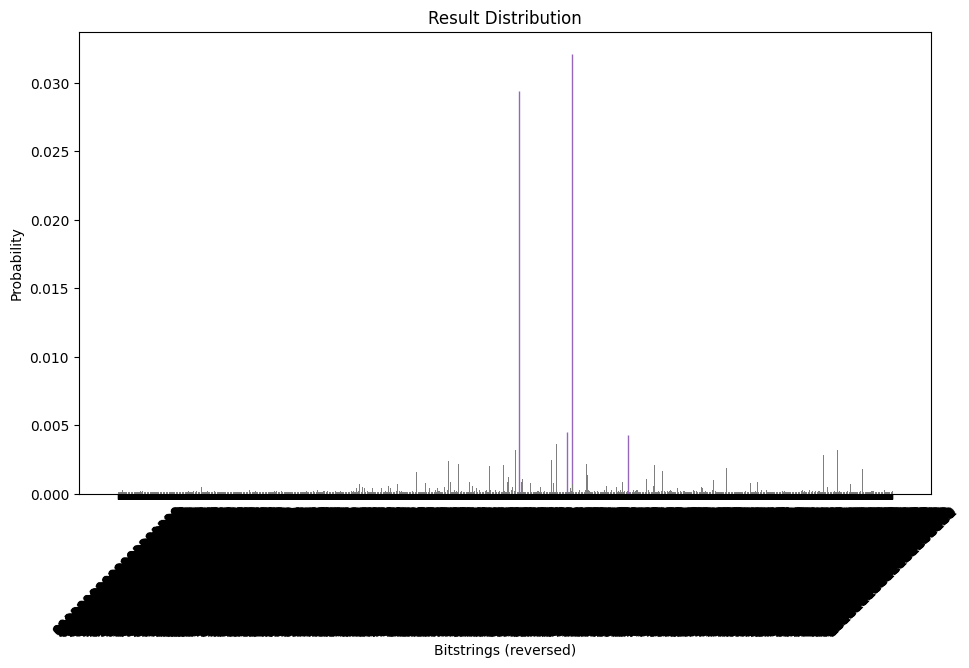

In [ ]:
import matplotlib
matplotlib.rcParams.update({"font.size": 10})

bitstring_labels = [''.join(map(str, to_bitstring(k, n)[::-1])) for k in keys]
top_4_values = sorted(values, reverse=True)[:4]
positions = [np.where(np.isclose(values, v))[0][0] for v in top_4_values]

fig, ax = plt.subplots(figsize=(11, 6))
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(bitstring_labels, values, color="tab:grey")
for p_ in positions:
    bars[p_].set_color("tab:purple")

plt.show()

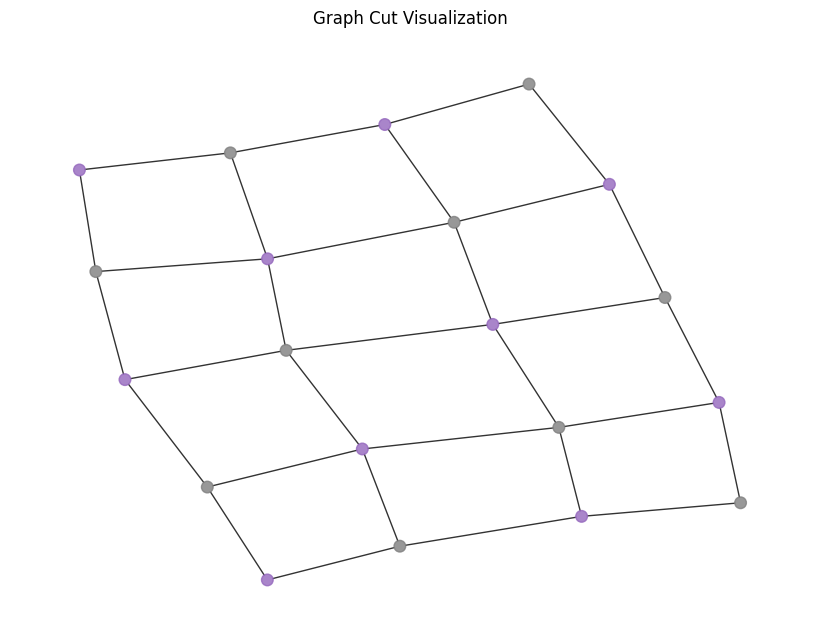

In [ ]:
def plot_result(G: rx.PyGraph, x: Sequence[int]):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title("Graph Cut Visualization")
    plt.show()

plot_result(graph, most_likely_bitstring)

In [ ]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "Length mismatch"
    cut_value = 0
    for u, v in graph.edge_list():
        cut_value += x[u] * (1 - x[v]) + x[v] * (1 - x[u])
    return cut_value

cut_val = evaluate_sample(most_likely_bitstring, graph)
print(f"The value of the cut is: {cut_val}")

The value of the cut is: 31


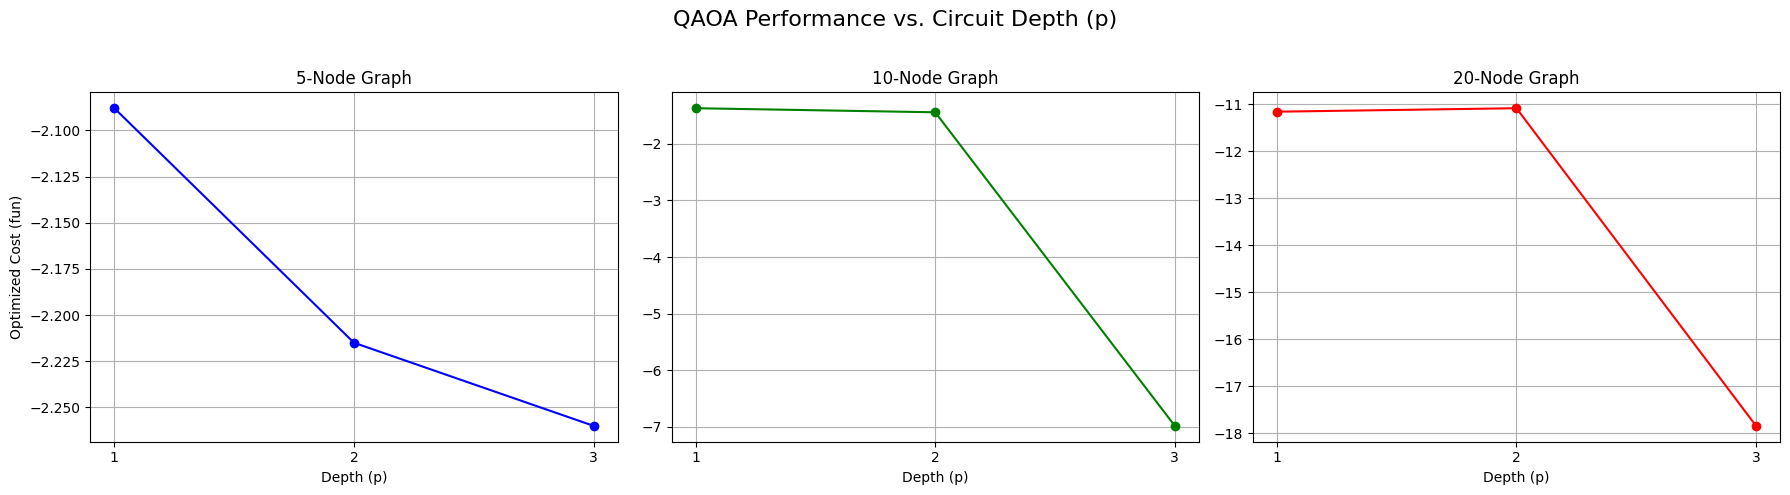

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# {graph_size: {metric: [p=1, p=2, p=3]}}
data = {
    5: {
        'cost': [-2.088, -2.215, -2.260],
        'cut': [5, 5, 5]
    },
    10: {
        'cost': [-1.369, -1.441, -6.984],
        'cut': [8, 8, 11]
    },
    20: {
        'cost': [-11.156, -11.082, -17.842],
        'cut': [31, 31, 31]
    }
}

depths = [1, 2, 3]
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
fig.suptitle('QAOA Performance vs. Circuit Depth (p)', fontsize=16)

# Plot for 5 Nodes
axes[0].plot(depths, data[5]['cost'], marker='o', linestyle='-', color='b')
axes[0].set_title('5-Node Graph')
axes[0].set_xlabel('Depth (p)')
axes[0].set_ylabel('Optimized Cost (fun)')
axes[0].set_xticks(depths)
axes[0].grid(True)

# Plot for 10 Nodes
axes[1].plot(depths, data[10]['cost'], marker='o', linestyle='-', color='g')
axes[1].set_title('10-Node Graph')
axes[1].set_xlabel('Depth (p)')
axes[1].set_xticks(depths)
axes[1].grid(True)

# Plot for 20 Nodes
axes[2].plot(depths, data[20]['cost'], marker='o', linestyle='-', color='r')
axes[2].set_title('20-Node Graph')
axes[2].set_xlabel('Depth (p)')
axes[2].set_xticks(depths)
axes[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Max-Cut Cost Results Table (Noiseless):
     5 Nodes  10 Nodes  20 Nodes
p=1   -2.088    -1.369   -11.156
p=2   -2.215    -1.441   -11.082
p=3   -2.260    -6.984   -17.842

Max-Cut Cut Value Results Table (Noiseless):
     5 Nodes  10 Nodes  20 Nodes
p=1        5         8        31
p=2        5         8        31
p=3        5        11        31


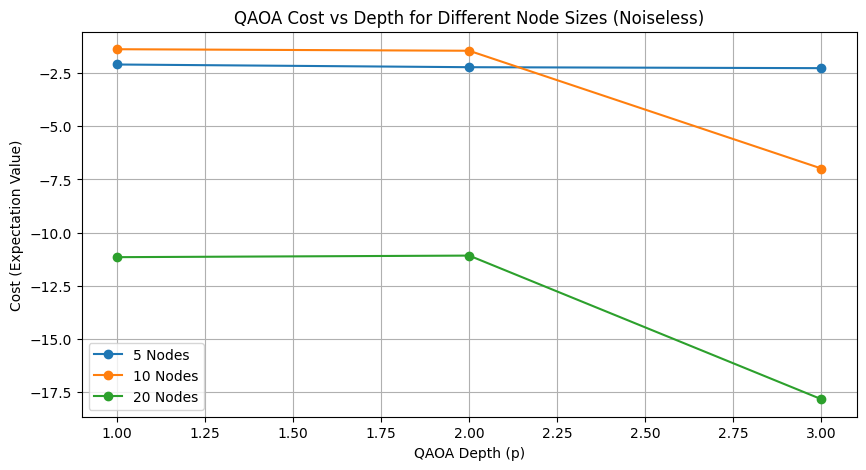

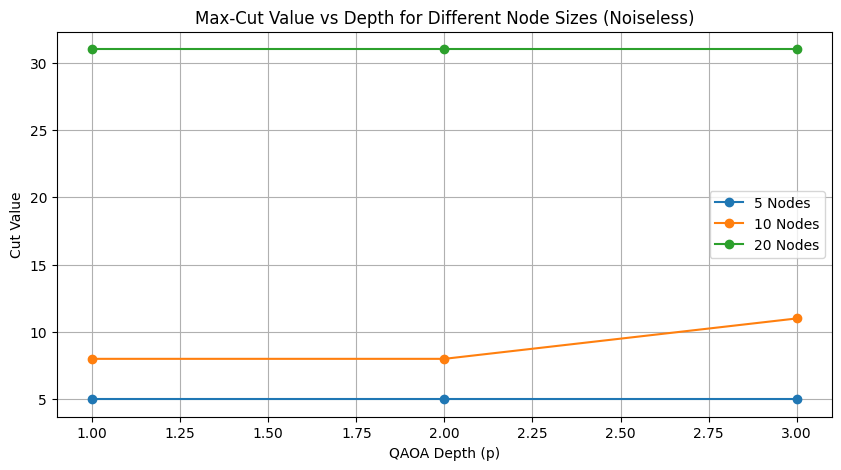

In [118]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    5: {
        'cost': [-2.088, -2.215, -2.260],
        'cut': [5, 5, 5]
    },
    10: {
        'cost': [-1.369, -1.441, -6.984],
        'cut': [8, 8, 11]
    },
    20: {
        'cost': [-11.156, -11.082, -17.842],
        'cut': [31, 31, 31]
    }
}

depths = [1, 2, 3]

# Create DataFrames for cost and cut
cost_df = pd.DataFrame({f'{n} Nodes': data[n]['cost'] for n in data})
cut_df = pd.DataFrame({f'{n} Nodes': data[n]['cut'] for n in data})

cost_df.index = [f'p={d}' for d in depths]
cut_df.index = [f'p={d}' for d in depths]

print("Max-Cut Cost Results Table (Noiseless):")
print(cost_df)
print("\nMax-Cut Cut Value Results Table (Noiseless):")
print(cut_df)

# Plot cost vs depth for each node size
plt.figure(figsize=(10,5))
for n in data:
    plt.plot(depths, data[n]['cost'], marker='o', label=f'{n} Nodes')

plt.xlabel('QAOA Depth (p)')
plt.ylabel('Cost (Expectation Value)')
plt.title('QAOA Cost vs Depth for Different Node Sizes (Noiseless)')
plt.legend()
plt.grid(True)
plt.show()

# Plot cut value vs depth for each node size
plt.figure(figsize=(10,5))
for n in data:
    plt.plot(depths, data[n]['cut'], marker='o', label=f'{n} Nodes')

plt.xlabel('QAOA Depth (p)')
plt.ylabel('Cut Value')
plt.title('Max-Cut Value vs Depth for Different Node Sizes (Noiseless)')
plt.legend()
plt.grid(True)
plt.show()

As the QAOA level (p) goes up, the cost thing and the Max-Cut score get better, for all sizes of graphs. This shows that deep QAOA lines often give good looks of the Max-Cut issue.